## Classification






### Table of Content
* [User Function(s)](#User_functions)
* [Feature Wrangling for ML](#features)
    * [Feature Selection](#feature_selection)
    * [Dataset Description](#describe)
    * [Heat Map](#heat_map)
    * [Class Distribution Plot](#class_dist)
    * [Split Dataset](#train_test_split)
    * [Scaling Dataset](#scale)
* [Feature Selection](#feature_selection_chi2)
* [Machine Learning Model(s)](#ml)
    * [Random Forest](#rfc)
    * [Logistic Regression](#lrc)
    * [AdaBoost Classifier](#adac)
    * [Linear Discriminant Analysis](#lda)
    * [Classfiucation Summary](#summary_full)
    * [SelectKBest Feature Selection](#kbest)
        * [AdaBoost with SelectKBest](#adakbest)
    * [Random Forest Tuning](#stack_tune)
        * [Stacking ML](#stacking)
    * [ML Model Summary](#model_summary)
* [Over & Under Sampling](#sampling)
    * [Random Forest Over Sampling](#rfc_over)
    * [Logistic Regression Over Sampling](#lrc_over)
    * [AdaBoost Classifier Over Sampling](#adac_over)
        * [Over Sampling Summary](#over_summary) 
    * [Random Forest Under Sampling](#rfc_under)
    * [Logistic Regression Under Sampling](#lrc_under)
    * [AdaBoost Classifier Under Sampling](#adac_under)
        * [Under Sampling Summary](#under_summary)
* [Conclusion](#conclude)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# set seaborn theme
sns.set_theme()

# random state seed
RANDOM_STATE = 1776

# print version
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)

# display option
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Numpy Version: 1.26.2
Pandas Version: 2.1.3
Seaborn Version: 0.13.0


In [2]:
# import libraries
from datetime import datetime
from sklearn import metrics 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import feature_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
# load cleaned dataset
df = pd.read_csv("./input/engineered_data.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45529 entries, 0 to 45528
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  45529 non-null  int64  
 1   budget                 8911 non-null   float64
 2   genres                 45529 non-null  int64  
 3   homepage               45529 non-null  int64  
 4   id                     45529 non-null  int64  
 5   overview               44575 non-null  object 
 6   popularity             45526 non-null  float64
 7   poster_path            45143 non-null  object 
 8   production_companies   45529 non-null  int64  
 9   production_countries   45529 non-null  int64  
 10  release_date           45443 non-null  object 
 11  revenue                7428 non-null   float64
 12  runtime                45529 non-null  float64
 13  spoken_languages       45529 non-null  int64  
 14  tagline                20433 non-null  object 
 15  ti

### User Function(s) <a class='anchor' id="User_functions"></a>

In [5]:
def get_quarter(date_str):
    """
    Determine the quarter from month of the date
    """
    # convert the date string to a string if it's not already
    # date_str = str(date_str)
    if pd.isna(date_str):
        return np.nan
    else:
        # convert the date string to a datetime object
        date = datetime.strptime(date_str, '%Y-%m-%d')
        
        # determine the quarter from the month of the date
        quarter = (date.month - 1) // 3 + 1
        
        return int(quarter)


def labelClass(ratioValue):
    """
    Catorgorized ration value in return feature
    Class: 0 = False
    Class: 1 = True
    """
    #
    if ratioValue <= 1:
        return 0
    elif ratioValue > 1:
        return 1
    else:
        return np.nan


def Curve(models, X, y):
    """
    Helper function top plot multiple Models ROC Curves.
    """

    # create a figure and axes with subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Below for loop iterates through your models list
    for m in models:
        model = m['model'] # select the model
        model.fit(X, y) # train the model
        # predict class
        y_pred = model.predict(X)
        # get predicted probabilities
        y_hat = model.predict_proba(X)

        # determine precision score
        average_precision = metrics.average_precision_score(y, y_hat[:,1])

        # determine precision & recall
        precision, recall, thresholds = metrics.precision_recall_curve(y, y_hat[:,1])

        # determine F-Score
        fscore = (2 * precision * recall) / (precision + recall)
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        # display 
        print('\t\t\t\t\t\t\t\t\t\t\t' + 'Model=%s Best Threshold=%.3f, F-Score=%.3f' % (m['label'],thresholds[ix], fscore[ix]))
        # initialize variable
        bestlabel = 'Best for ' + m['label']
        
        # Compute False postive rate, and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(y, model.predict_proba(X)[:,1])
        # Calculate Area under the curve to display on the plot
        auc = metrics.roc_auc_score(y , model.predict(X))
        # Now, plot the computed values
        axs[0].plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
        axs[1].plot(recall, precision, label='%s Avg. prec. (area = %0.2f)' % (m['label'], average_precision))
        axs[1].scatter(recall[ix], precision[ix], marker=m['marker'], label=bestlabel)
        
    # Custom settings for the plot
    axs[0].plot([0, 1], [0, 1],'r--',label='No Skill')
    # axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel('1-Specificity(False Positive Rate)')
    axs[0].set_ylabel('Sensitivity(True Positive Rate)')
    axs[0].set_title('Receiver Operating Characteristic')
    axs[0].legend(loc="lower right")
    # axs[0].show()   # Display

    # Custom settings for the plot 
    # axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision Recall Curves')
    axs[1].legend(loc="lower left")


def plotBar(df_, stage=0):
    """
    Help function for Bar Plots of Balanced Accuracy & F-1 Scores
    """

    #
    df = df_.copy()
    # reset index
    df.reset_index(inplace=True)

    # sort by Algorithm
    df.sort_values(by=['Algorithm'], inplace=True)

    if stage == 0:
        str = ''
        # each model to DataFrame
        df1 = df[~df.Algorithm.str.contains("-")].copy()
        df2 = df[~df.Algorithm.str.contains("-")].copy()
    elif stage ==1:
        str= ''
        df1 = df[df.Algorithm.str.contains(":")].copy()
        df2 = df[df.Algorithm.str.contains(":")].copy()
    elif stage == 2:
        str = 'Over Sampling'
        df1 = df[df.Algorithm.str.contains("-Over")].copy()
        df1['Algorithm'] = df1['Algorithm'].apply(lambda x: x.split('-')[0])
        df2 = df[df.Algorithm.str.contains("-Over")].copy()
        df2['Algorithm'] = df2['Algorithm'].apply(lambda x: x.split('-')[0])
    else:
        str = 'Under Sampling'
        df1 = df[df.Algorithm.str.contains("-Under")].copy()
        df1['Algorithm'] = df1['Algorithm'].apply(lambda x: x.split('-')[0])
        df2 = df[df.Algorithm.str.contains("-Under")].copy()
        df2['Algorithm'] = df2['Algorithm'].apply(lambda x: x.split('-')[0])
   

    # create a figure and axes with subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # set the width of the bars
    bar_width = 0.35
    
    # create the positions for the bars
    positions1 = np.arange(len(df1))
    positions2 = np.arange(len(df2))
    
    # create the bar plot
    axs[0].bar(positions1 - bar_width/2, df1['Balanced Accuracy Train'], bar_width, label='Balanced Accuracy Train')
    axs[0].bar(positions1 + bar_width/2, df1['Balanced Accuracy Test'], bar_width, label='Balanced Accuracy Test')
    
    # create the bar plot
    axs[1].bar(positions2 - bar_width/2, df2['F1 Train'], bar_width, label='F1 Accuracy Train')
    axs[1].bar(positions2 + bar_width/2, df2['F1 Test'], bar_width, label='F1 Accuracy Test')
    
    # label & heading infomation
    axs[0].set_xlabel('Algorithm')
    axs[0].set_ylabel('Balanced Accuracy')
    axs[0].set_title(f"Comparison of \nBalanced Accuracy Train and Test for Different Algorithms\n{str}")
    axs[0].set_yticks(np.arange(0.0, 1.1, 0.1))
    axs[0].set_xticks(positions1, df1['Algorithm'], rotation=45, ha='right')
    axs[0].legend()
    
    # label & heading infomation
    axs[1].set_xlabel('Algorithm')
    axs[1].set_ylabel('F1 Accuracy')
    axs[1].set_title(f"Comparison of \nF-1 Accuracy Train and Test for Different Algorithms\n{str}")
    axs[1].set_yticks(np.arange(0.0, 1.1, 0.1))
    axs[1].set_xticks(positions2, df2['Algorithm'], rotation=45, ha='right')
    axs[1].legend()
    
    plt.tight_layout()
    
    # Show the plot
    plt.show()


def featureSelection(X, y, df, score='roc_auc'):
    """
    Help function for feature selection
    """
    # initialize variables
    percentiles = range(1, 100, 5)
    results = []
    
    # create DecisionTreeClassifier
    dtc = DecisionTreeClassifier(criterion='entropy')
    
    # instantiate Stratified K-Fold cross-validation takes into account the class distribution
    cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    # iterate 
    for i in range(1, 100, 5):
        fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=i)
        # fs = feature_selection.SelectPercentile(feature_selection.f_classif, percentile=i)
        X_train_fs = fs.fit_transform(X, y)
        # evaluate a score by cross-validation
        scores = cross_val_score(dtc, X=X, y=y, scoring=score, cv=cv, n_jobs=-1)
        # print (i,scores.mean())
        results = np.append(results, scores.mean())
    
    optimal_percentile = np.where(results == results.max())[0]
    optimal_num_features = int(percentiles[optimal_percentile[0]]*len(df.columns)/100)
    # initialize variables
    percent = percentiles[optimal_percentile[0]]
    feature = optimal_num_features

    return percent, feature


def calc_params(X, y, clf, param_values, param_name, K):
    
    # Convert input to Numpy arrays
    X = np.array(X)
    y = np.array(y)

    # initialize training and testing score arrays with zeros
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    # iterate over the different parameter values
    for i, param_value in enumerate(param_values):

        # set classifier parameters
        clf.set_params(**{param_name:param_value})
        
        # initialize the K scores obtained for each fold
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        # create KFold cross validation
        cv = KFold(n_splits=K, shuffle=True, random_state=0)
        
        # iterate over the K folds
        j = 0
        for train, test in cv.split(X):
            # fit the classifier in the corresponding fold
            # and obtain the corresponding accuracy scores on train and test sets
            clf.fit(X[train], y[train])
            k_train_scores[j] = clf.score(X[train], y[train])
            k_test_scores[j] = clf.score(X[test], y[test])
            j += 1
            
        # store the mean of the K fold scores
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
        print(param_name, '=', param_value, "Train =", train_scores[i], "Test =", test_scores[i])
       
    # plot the training and testing scores in a log scale
    plt.plot(param_values, train_scores, label='Train', alpha=0.4, lw=2, c='b')
    plt.plot(param_values, test_scores, label='X-Val', alpha=0.4, lw=2, c='g')
    plt.legend(loc=7)
    plt.xlabel(param_name + " values")
    plt.ylabel("Mean cross validation accuracy")

    return

In [6]:
def classifier_metrics(model, X, y, flag = None):
    """
    Classfication metric for Project incldues 
    Model metrics & Confusion Matrix.
    """
    # predictions
    pred = model.predict(X)
    
    # calculate the confusion matrix
    tn, fp, fn, tp = metrics.confusion_matrix(y, pred).ravel()
                                       
    # classification report calculation
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    balanced_accuracy = 1/2 * (tn / (tn + fp)) + (tp / (tp + fn)) / 2
    f1_score  = 2 * ((precision * recall) / (precision + recall))

    # print msgs
    if flag:
        print("*" * 5 + " Classfication Metrics for Validation/Test:")
    else:
        print("*" * 5 + " Classfication Metrics for Training:")
        
    print(f"Recall (Sensitivity): " + " "*2 + f"{recall:.4f}")
    print(f"Specificity: " + " "*11 + f"{specificity:.4f}")   
    print(f"Precision: " + " "*13 + f"{precision:.4f}")
    print(f"Balanced Accuracy: " + " "*5 + f"{balanced_accuracy:.4f}")
    print(f"F1 Score: " + " "*14 + f"{f1_score:.4f}")
    print("\n")

    # create confusion matrix
    cm = metrics.confusion_matrix(y, pred, labels=model.classes_)

    # create the ConfusionMatrixDisplay with labels
    cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels = model.classes_)

    # plot the confusion matrix
    cm_display.plot(cmap='Blues', values_format='d', colorbar=False)
    
    #
    if flag:
        cm_display.ax_.set_title("Validation/Test Confusion Matrix", fontsize=16)
    else:
        cm_display.ax_.set_title("Training Confusion Matrix", fontsize=16)

    # Turn off the grid
    plt.grid(False)
    
    # plot
    plt.show()
    
    # spacing
    print("\n")
    
    return recall, specificity, precision, balanced_accuracy, f1_score


def kfold_grid(model, parameters, X_train, y_train, score = 'roc_auc'):
    """
    Ten fold CV Stratified
    """
    # instantiate Stratified K-Fold cross-validation takes into account the class distribution
    cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

    # perform GridSearchCV
    GSC_estimator = GridSearchCV(model, parameters, scoring=score, cv=cv, n_jobs=-1)

    # evaluate a score by cross-validation
    scores = cross_val_score(GSC_estimator, X=X_train, y=y_train, scoring=score, cv=cv, n_jobs=-1)

    # print average accuracy score CV with standard deviation
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

    # fit model
    fit = GSC_estimator.fit(X_train, y_train)
    
    return fit


def plot_feature_importance(model, df):
    """
    Plot feature importance from the model
    Order List & Bar Plot of Importance
    """
    # create dataframe
    df = pd.DataFrame(model.feature_importances_ * 100, index=X.columns, columns=["% Feature Importance"])
    print(df.sort_values("% Feature Importance", axis=0, ascending=False))
    # bar plot
    plt.figure(figsize=(10,5))
    # create a bar plot using Seaborn
    ax = sns.barplot(data=df, y=df.index, x = df['% Feature Importance'], orient= 'h')
    ax.set_title("Feature Importance Bar Plot", fontsize = 15)
    # add a grid to the x-axis
    plt.grid(axis='x', linestyle='--')
    plt.show()
    
    
def classifier_performance_dict(ML, model, X_train, y_train, X_val, y_val):
    """
    Use the helper function to populate the dictionary with 
    performance matrics.
    """
    # initialize model performance dictionary
    prediction_info = {"Algorithm" : [],
               "Model Name" : [],
               "Model Parameters": [],
               "Recall(Sensitivity) Train": [],
               "Specificity Train": [],
               "Precision Train": [],
               "Balanced Accuracy Train": [],
               "F1 Train": [],
               "Recall(Sensitivity) Test": [],
               "Specificity Test": [],
               "Precision Test": [],
               "Balanced Accuracy Test": [],
               "F1 Test": [],
              }
    
    # initialize dict keys
    keys = ["Algorithm", "Model Name", "Model Parameters", "Recall(Sensitivity) Train",  "Specificity Train", \
            "Precision Train", "Balanced Accuracy Train", "F1 Train", "Recall(Sensitivity) Test", \
            "Specificity Test", "Precision Test", "Balanced Accuracy Test", "F1 Test"]
    
    # model infomation
    ML_info = model.get_params()

    # metrics for train & validation
    recall_train, spec_train, prec_train, ba_train, f1_train = classifier_metrics(model, X_train, y_train)
    recall_val, spec_val, prec_val, ba_val, f1_val = classifier_metrics(model, X_val, y_val, True)

    # create list
    data = [ML, model, ML_info, recall_train, spec_train, prec_train, ba_train, f1_train, \
            recall_val, spec_val, prec_val, ba_val, f1_val]

    # append to dictionary
    for key, data in zip(keys,data):
        prediction_info[key].append(data)
        
    # create dataframe from dictionary
    df = pd.DataFrame(prediction_info)

    # make the first column 'Algorithm' the new index
    df.set_index('Algorithm', inplace=True)
    
    return df


# empty dataframe for performance
classify_performance_df = pd.DataFrame()

### Feature Wrangling <a class='anchor' id="features"></a>

In [7]:
# chhecking for NaN release_date
df.release_date.isnull().sum()

86

In [8]:
# release_date in what quarter movie was released
df['release_quarter'] = df['release_date'].apply(get_quarter)

In [9]:
# checking for NaN in release_quarter
df.release_quarter.isnull().sum()

86

In [10]:
# class column using return feature
df['label'] = df['return'].apply(labelClass)

In [11]:
df.label.value_counts(dropna=False)

label
NaN    40136
1.0     3764
0.0     1629
Name: count, dtype: int64

In [12]:
# remove all the NaN label
df_clean = df[df['label'].isin([True,False])].copy()

In [13]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5393 entries, 0 to 45485
Data columns (total 49 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  5393 non-null   int64  
 1   budget                 5393 non-null   float64
 2   genres                 5393 non-null   int64  
 3   homepage               5393 non-null   int64  
 4   id                     5393 non-null   int64  
 5   overview               5382 non-null   object 
 6   popularity             5393 non-null   float64
 7   poster_path            5393 non-null   object 
 8   production_companies   5393 non-null   int64  
 9   production_countries   5393 non-null   int64  
 10  release_date           5393 non-null   object 
 11  revenue                5393 non-null   float64
 12  runtime                5393 non-null   float64
 13  spoken_languages       5393 non-null   int64  
 14  tagline                4637 non-null   object 
 15  title   

#### Feature Selction <a class='anchor' id="feature_selection"></a>

- `id`: film ID
- `revenue`: unknown for a new film
- `year`: repetitive feature
- `return`: used to create binary `label` feature

In [14]:
# include features
columnsIncldue = ['belongs_to_collection', 'popularity', 'genres', 'production_companies', 'production_countries', 'runtime', 'spoken_languages', \
                  'cast_size', 'crew_size', 'vote_count', 'is_english', 'is_Friday', 'is_Holiday', 'release_quarter', 'budget', 'label']

# copy DataFrame
clean = df_clean.copy()

# drop features
clean = clean[columnsIncldue]

In [15]:
# info
clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5393 entries, 0 to 45485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  5393 non-null   int64  
 1   popularity             5393 non-null   float64
 2   genres                 5393 non-null   int64  
 3   production_companies   5393 non-null   int64  
 4   production_countries   5393 non-null   int64  
 5   runtime                5393 non-null   float64
 6   spoken_languages       5393 non-null   int64  
 7   cast_size              5393 non-null   int64  
 8   crew_size              5393 non-null   int64  
 9   vote_count             5393 non-null   float64
 10  is_english             5393 non-null   int64  
 11  is_Friday              5393 non-null   int64  
 12  is_Holiday             5393 non-null   int64  
 13  release_quarter        5393 non-null   float64
 14  budget                 5393 non-null   float64
 15  label   

In [16]:
# convert to int
clean.release_quarter = clean.release_quarter.astype(int)
clean.label = clean.label.astype(int)

### Describe <a class='anchor' id="describe"></a>

- This dataset contains a wide range of values, and no NaN values are present in the current dataset. 

In [17]:
# describe DataFrame
clean.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
belongs_to_collection,5393.0,2.273317e-01,4.191475e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
popularity,5393.0,9.764355e+00,1.380559e+01,0.000001,5.430566e+00,8.378149e+00,1.169809e+01,5.474883e+02
genres,5393.0,2.604858e+00,1.127692e+00,0.000000,2.000000e+00,3.000000e+00,3.000000e+00,8.000000e+00
production_companies,5393.0,2.942704e+00,2.190708e+00,0.000000,1.000000e+00,2.000000e+00,4.000000e+00,2.600000e+01
production_countries,5393.0,1.361209e+00,7.917842e-01,0.000000,1.000000e+00,1.000000e+00,2.000000e+00,1.200000e+01
runtime,5393.0,1.098081e+02,2.202914e+01,0.000000,9.500000e+01,1.060000e+02,1.200000e+02,3.380000e+02
spoken_languages,5393.0,1.481179e+00,9.270838e-01,0.000000,1.000000e+00,1.000000e+00,2.000000e+00,9.000000e+00
cast_size,5393.0,2.374764e+01,2.060569e+01,0.000000,1.200000e+01,1.700000e+01,2.700000e+01,3.130000e+02
crew_size,5393.0,2.928148e+01,3.301757e+01,0.000000,9.000000e+00,1.700000e+01,3.500000e+01,4.350000e+02
vote_count,5393.0,7.309173e+02,1.250482e+03,0.000000,7.700000e+01,2.760000e+02,7.950000e+02,1.407500e+04


### Heatmap <a class='anchor' id="heat_map"></a>

- Examining the correlation heatmap shows no sign of highly correlated features.

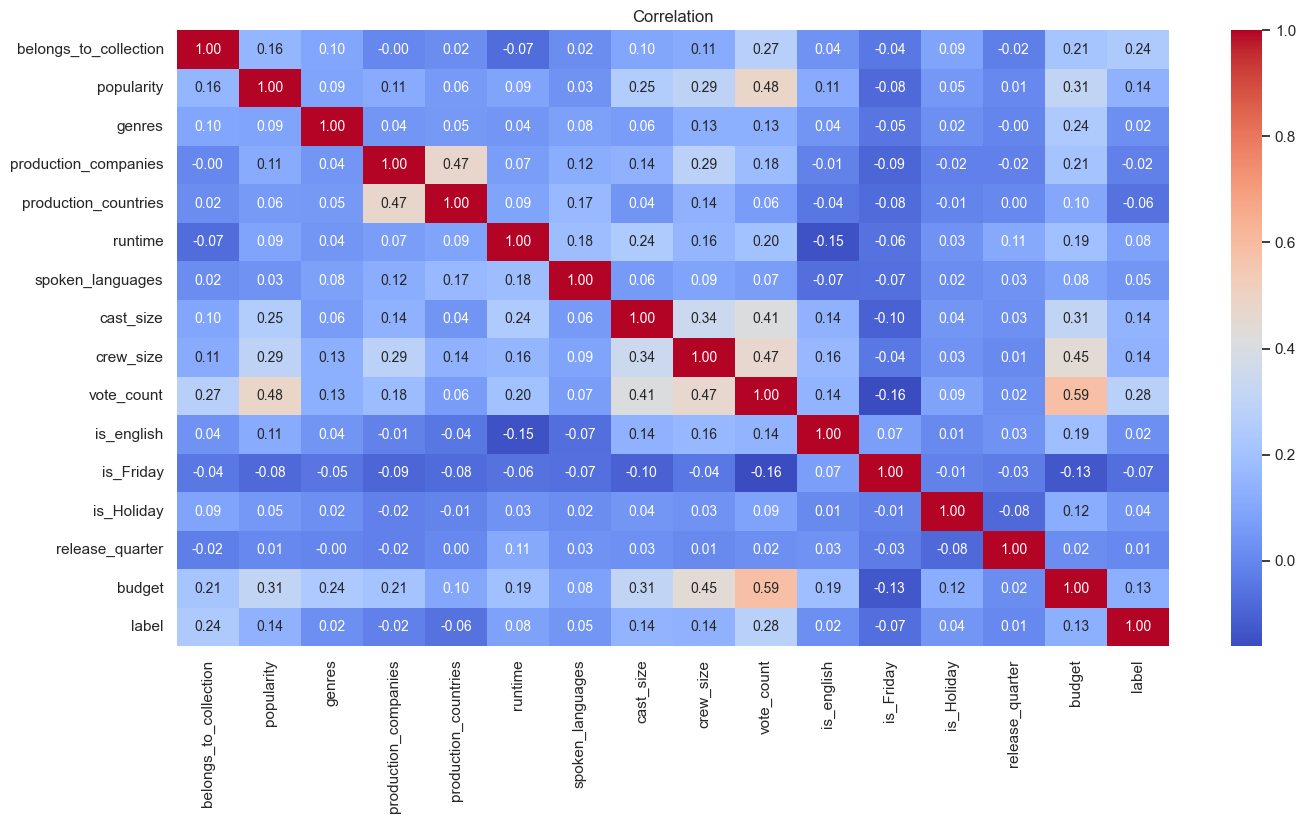

In [18]:
# heat map plot
plt.figure(figsize=(16,8))
plt.title("Correlation")
sns.heatmap(clean.corr(), annot=True, cmap="coolwarm", annot_kws={"fontsize": 10}, fmt=".2f")
plt.show()

In [19]:
# checking for nulls
clean.isnull().sum()

belongs_to_collection    0
popularity               0
genres                   0
production_companies     0
production_countries     0
runtime                  0
spoken_languages         0
cast_size                0
crew_size                0
vote_count               0
is_english               0
is_Friday                0
is_Holiday               0
release_quarter          0
budget                   0
label                    0
dtype: int64

### Class Distribution Plot <a class='anchor' id="class_dist"></a>

- In this dataset, we have more positive cases that are successful or generate positive revenue than unsuccessful cases.

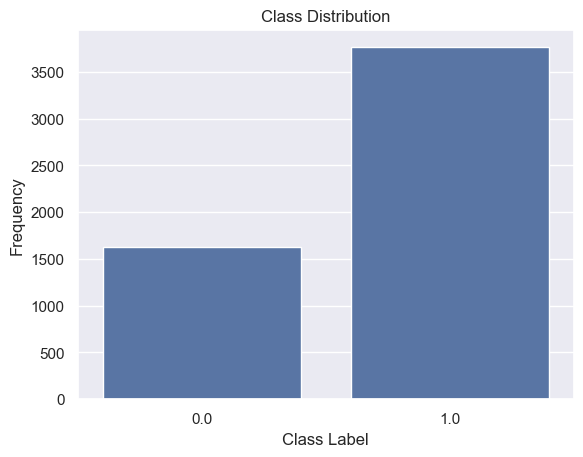

In [20]:
# label distribution plot
sns.countplot(df_clean, x='label')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

### Train & Test <a class='anchor' id="train_test_split"></a>

- 80% Training & 20% Testing

In [21]:
# initialize X & y variable
X = clean.drop('label', axis = 1)
y = clean.label

# split train & test using stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)

In [22]:
print(f"Training Dataset Shape: {X_train.shape}")
print(f"Testing Dataset Shape:  {X_test.shape}")

Training Dataset Shape: (4314, 15)
Testing Dataset Shape:  (1079, 15)


### Convert to Numpy Array

In [23]:
# convert to array
X_train_arr = X_train.values
X_test_arr = X_test.values
y_train_arr = y_train.values.ravel()
y_test_arr = y_test.values.ravel()

In [24]:
# display shape (training & testing)
print(f"Training Dataset Shape: {X_train_arr.shape} & Label Shape: {y_train_arr.shape}")
print(f"Testing Dataset Shape:  {X_test_arr.shape} & Label Shape: {y_test_arr.shape}")

Training Dataset Shape: (4314, 15) & Label Shape: (4314,)
Testing Dataset Shape:  (1079, 15) & Label Shape: (1079,)


### Scale Data <a class='anchor' id="scale"></a>
- We use Z-Score for ML models and Min Max scaling for the `SelectPercentile(feature_selection.chi2)` feature selection.

In [25]:
# instantiate scale
scale = StandardScaler()

# fit
fit = scale.fit(X_train_arr)

# transform train & test
X_train_scaled = fit.transform(X_train_arr)
X_test_scaled = fit.transform(X_test_arr)

In [26]:
# instantiate scale
minmax = MinMaxScaler()

# fit
fit_mm = minmax.fit(X_train_arr)

# transform train & test
X_train_mm = fit_mm.transform(X_train_arr)
X_test_mm = fit_mm.transform(X_test_arr)

### Evaluate our best number of features <a class='anchor' id="feature_selection_chi2"></a>
- Using the `DecisionTreeClassifierthe ` with the `feature_selection.chi2` function appears inconsistent since the number of features and percentiles differs widely during ten iterations.

In [27]:
# initialize list
percent = []
feature = []
runs = []

# iterate
for i in range(10):
    p, f = featureSelection(X_train_mm, y_train_arr, X)
    percent.append(p)
    feature.append(f)
    runs.append(i+1)

# convert list of tuples to DataFrame
df = pd.DataFrame(list(zip(runs, percent, feature)), columns=['iteration', 'percentile', 'features'])

# reindexing with Column1
df = df.set_index('iteration')

# display
df

,percentile,features
iteration,,
1,56,8
2,21,3
3,81,12
4,46,6
5,91,13
6,51,7
7,76,11
8,11,1
9,51,7


### Machine Learning Model(s) <a class='anchor' id="ml"></a>

We selected multiple models to compare the performance for our classification using Randon Forest, Logistic Regression, AdaBoost with Decision Tree as the weak learner, and Linear Discrement Analysis with ten-fold cross-validation and every model was Hyperparameter tuned. Also, we incldued over/under sampling techniques to determine the performance of our models. 

In our exercise we are comparing all the models using `Balanced Accuracy` which a metric used to evaluate the performance of a classification model, especially where the classes are imbalanced. It is defined as each class's arithmetic mean of sensitivity (true positive rate) and specificity (true negative rate). Also, `F-1` score is being used in conjuction to evaluate the performance of classification models. It combines precision and recall into a single value and is calculated as the harmonic mean of precision and recall.

### Random Forest  <a class='anchor' id="rfc"></a>

Per our metrics, the RandomForestClassifier produces a `0.66` balanced accuracy and a `0.85` F-1 score on our test dataset. It is a viable model since the differences in metrics between train and test are less than 10%. Let's run three different classifiers to compare with our RandomForestClassifier model.

In [28]:
# define the hyperparameter grid to search
parameters = dict(
# minimum number of samples required to split a node
min_samples_split = list(np.linspace(40, 70, num=4, dtype=np.intc)),
# maximum number of levels in tree
max_depth = list(np.linspace(5,9, num=3, dtype=np.intc)), 
# number of trees in the forest
n_estimators = list(np.linspace(10, 125, num=4, dtype=np.intc)),
# function to measure the quality of a split
criterion = ['gini', 'entropy'],
)

# # instantiate Model
rfc_param = {'random_state': RANDOM_STATE}

# instantiate RandomForest Classifier
model = RandomForestClassifier(**rfc_param)

# CV with grid search for Hyper-Parameter tuning using Z-Score
fit = kfold_grid(model, parameters, X_train_scaled, y_train_arr)

CV accuracy: 0.808 +/- 0.029



RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=60,
                       n_estimators=48, random_state=1776)

***** Classfication Metrics for Training:
Recall (Sensitivity):   0.9479
Specificity:            0.4705
Precision:              0.8053
Balanced Accuracy:      0.7092
F1 Score:               0.8708




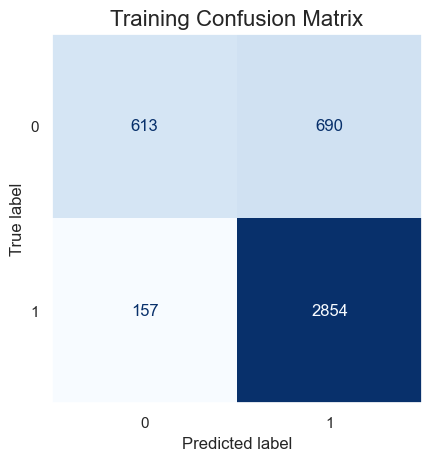



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.9230
Specificity:            0.3988
Precision:              0.7800
Balanced Accuracy:      0.6609
F1 Score:               0.8455




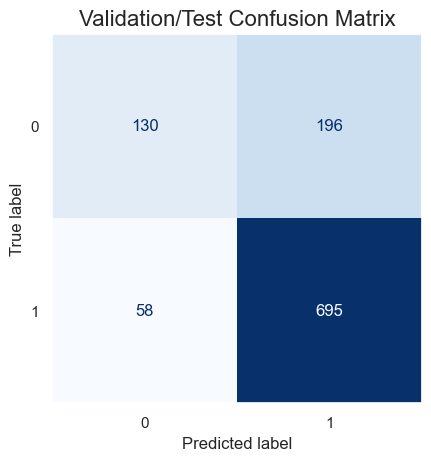



                       % Feature Importance
vote_count                        37.310530
popularity                        12.801872
belongs_to_collection             10.493926
budget                            10.172953
cast_size                          5.324248
runtime                            5.227586
crew_size                          4.922495
production_countries               4.292280
production_companies               4.179296
genres                             1.643320
spoken_languages                   1.025686
is_english                         1.014749
release_quarter                    0.744497
is_Friday                          0.456844
is_Holiday                         0.389717


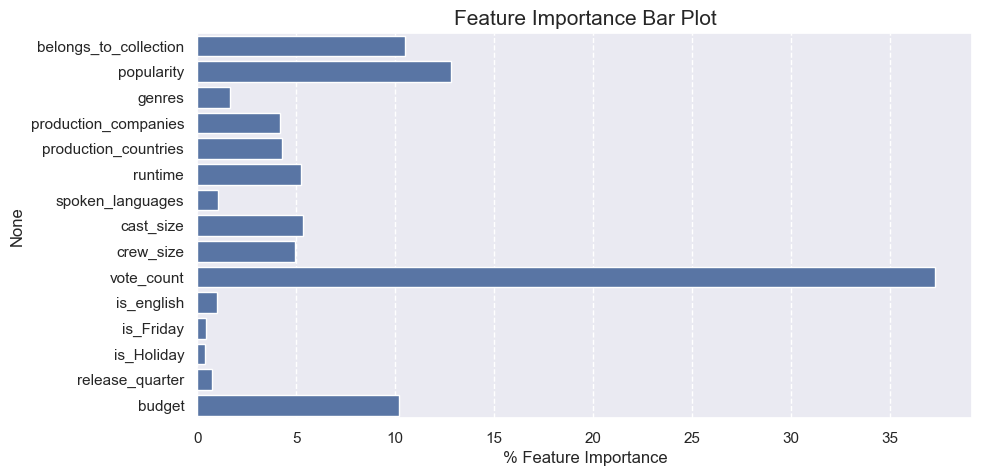

,Recall(Sensitivity) Train,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,,
RandomForestClassifier,0.947858,0.470453,0.805305,0.709155,0.870786,0.922975,0.398773,0.780022,0.660874,0.845499


In [29]:
ML = "RandomForestClassifier"
model_rfc = fit.best_estimator_

# display the best model
print(f"\n{model_rfc}\n")

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model_rfc, X_train_scaled, y_train_arr, X_test_scaled, y_test_arr)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

# feature importance
plot_feature_importance(model_rfc, clean)

df_.iloc[:, 2:]

### Logistic Regression  <a class='anchor' id="lrc"></a>

Per our metrics, the LogisticRegression produces a `0.70` balanced accuracy and a `0.85` F-1 score on our test dataset. It is a viable model since the differences in metrics between train and test are less than 10%.

In [30]:
# define the hyperparameter grid to search
parameters = dict(
# Inverse of regularization strength; must be a positive float
C = np.round(np.linspace(0.15, 5, 15),2),
# Maximum number of iterations taken for the solvers to converge.
max_iter = list(np.linspace(50, 300, num=5, dtype=np.intc)),
# Weights associated with classes in the form & The “balanced” mode 
# uses the values of y to automatically adjust weights inversely 
# proportional to class frequencies in the input data
class_weight = ['balanced', None],
)
# Base Model
lr_param = {'random_state': RANDOM_STATE}

# instantiate Logistic Regression
model = LogisticRegression(**lr_param)

# CV with grid search for Hyper-Parameter tuning use Z-Score
fit = kfold_grid(model, parameters, X_train_scaled, y_train_arr)

CV accuracy: 0.800 +/- 0.022



LogisticRegression(C=3.61, max_iter=50, random_state=1776)

***** Classfication Metrics for Training:
Recall (Sensitivity):   0.8967
Specificity:            0.4390
Precision:              0.7869
Balanced Accuracy:      0.6678
F1 Score:               0.8382




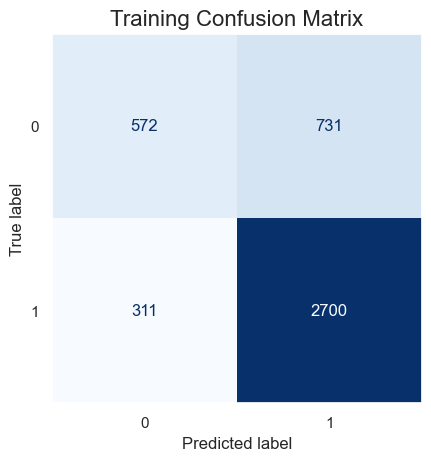



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.8938
Specificity:            0.5031
Precision:              0.8060
Balanced Accuracy:      0.6984
F1 Score:               0.8476




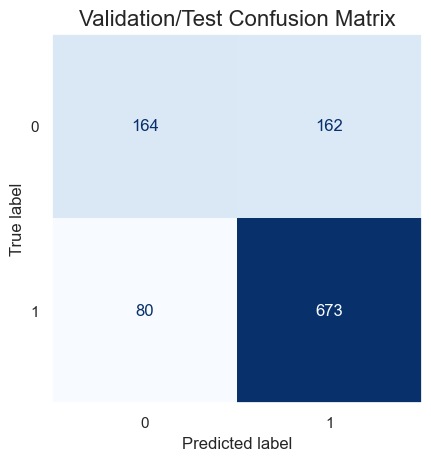

,Recall(Sensitivity) Train,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,,
LogisticRegression,0.896712,0.438987,0.786943,0.66785,0.838249,0.893758,0.503067,0.805988,0.698413,0.847607


In [31]:
ML = "LogisticRegression"
model_lrc = fit.best_estimator_

# display the best model
print(f"\n{model_lrc}\n")

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model_lrc, X_train_scaled, y_train_arr, X_test_scaled, y_test_arr)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:, 2:]

### AdaBoost Classifier <a class='anchor' id="adac"></a>

Per our metrics, the AdaBoost Classifier produces a `0.71` balanced accuracy and a `0.85` F-1 score on our test dataset. It is a viable model since the differences in metrics between train and test are less than 10%.

In [32]:
# hyper-parameters AdaBoost
# number of trees in the forest (default (50))
n_estimators = list(np.linspace(30, 150, num=5, dtype=np.intc))
# learning rate default(1)
learning_rate = np.round(np.logspace(-2, 0.2 , 4), 2)

# Define the parameter grid for AdaBoostClassifier and the base DecisionTreeClassifier
parameters = {
    # Decision Tree tuning
    'estimator__max_depth': [3, 5, 7],
    'estimator__criterion': ['gini','entropy'],
    'estimator__min_samples_split': [5, 10, 15],
    # AdaBoost Tuning
    'n_estimators': n_estimators,  # Number of boosting stages
    'learning_rate': learning_rate,  # Weight applied to each classifier at each boosting iteration
}

# create DecisionTreeClassifier as estimator (weak learner)
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Base Model
ada_param = {'estimator': dtc, 'algorithm':'SAMME', 'random_state': RANDOM_STATE}

# instantiate AdaBoost Classifier
model = AdaBoostClassifier(**ada_param)

# CV with grid search for Hyper-Parameter tuning use Z-Score
fit =  kfold_grid(model, parameters, X_train_scaled, y_train_arr)

CV accuracy: 0.813 +/- 0.029



AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=5,
                                                    min_samples_split=10,
                                                    random_state=1776),
                   learning_rate=0.05, n_estimators=150, random_state=1776)

***** Classfication Metrics for Training:
Recall (Sensitivity):   0.9166
Specificity:            0.4981
Precision:              0.8084
Balanced Accuracy:      0.7074
F1 Score:               0.8591




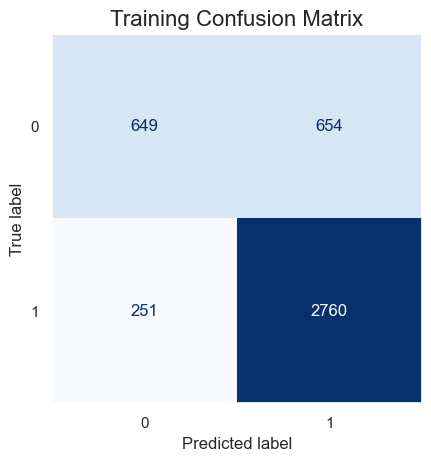



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.8951
Specificity:            0.5215
Precision:              0.8120
Balanced Accuracy:      0.7083
F1 Score:               0.8515




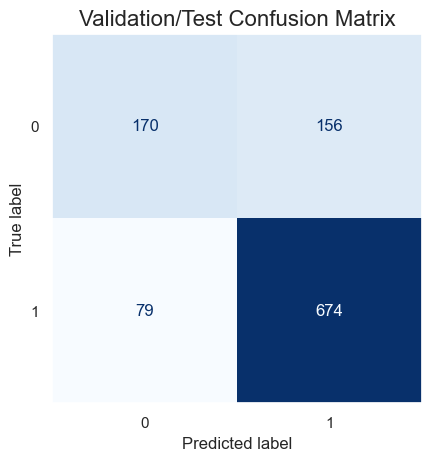



                       % Feature Importance
vote_count                     6.322899e+01
budget                         1.056905e+01
belongs_to_collection          9.404025e+00
runtime                        4.959986e+00
spoken_languages               2.144311e+00
crew_size                      2.123680e+00
genres                         1.818600e+00
popularity                     1.606896e+00
production_companies           1.369244e+00
release_quarter                1.076866e+00
production_countries           1.010863e+00
is_english                     3.362756e-01
cast_size                      2.762746e-01
is_Friday                      7.493793e-02
is_Holiday                     4.890171e-15


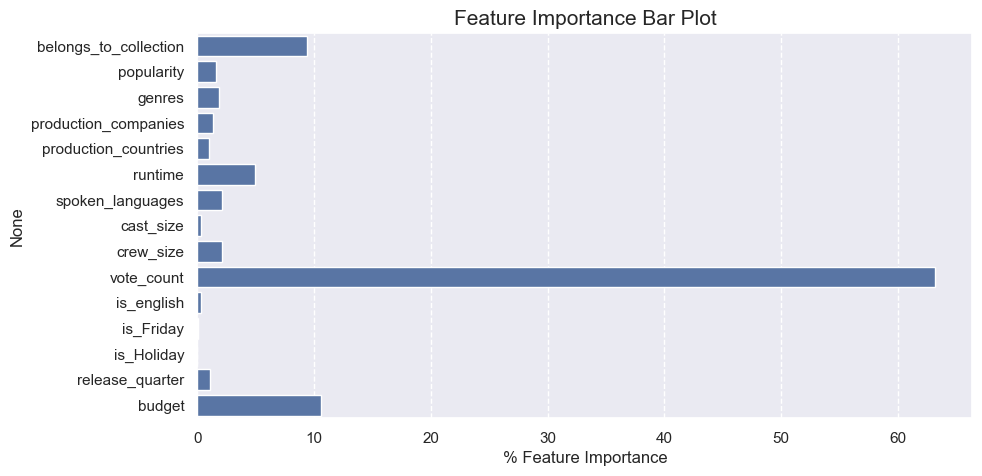

,Recall(Sensitivity) Train,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,,
AdaBoost,0.916639,0.498081,0.808436,0.70736,0.859144,0.895086,0.521472,0.812048,0.708279,0.851548


In [33]:
# initialize
ML = "AdaBoost"
model_adac = fit.best_estimator_

# display the best model
print(f"\n{model_adac}\n")

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model_adac, X_train_scaled, y_train_arr, X_test_scaled, y_test_arr)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

# feature importance
plot_feature_importance(model_adac, clean)

df_.iloc[:,2:]

### Linear Discriminant Analysis <a class='anchor' id="lda"></a>

In [34]:
# define the hyperparameter grid to search
parameters = {
    'solver': ['svd', 'lsqr', 'eigen']
}

# define default Linear Discriminant Analysis Classifier parameters 
lda_param = {
    'n_components': None,
}

# instantiate XGB Classifier
model = LinearDiscriminantAnalysis(**lda_param)

# CV with grid search for Hyper-Parameter tuning use Z-Score
fit = kfold_grid(model, parameters, X_train_scaled, y_train_arr)

CV accuracy: 0.752 +/- 0.026



LinearDiscriminantAnalysis()

***** Classfication Metrics for Training:
Recall (Sensitivity):   0.9851
Specificity:            0.0714
Precision:              0.7102
Balanced Accuracy:      0.5282
F1 Score:               0.8254




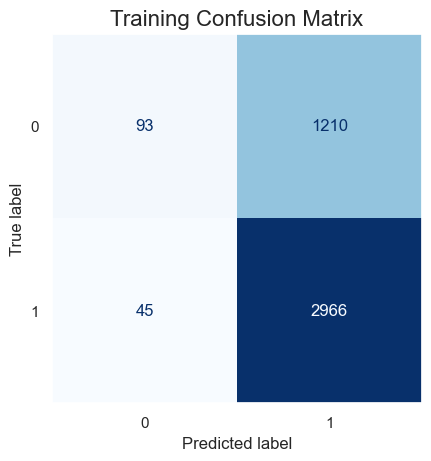



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.9814
Specificity:            0.0736
Precision:              0.7099
Balanced Accuracy:      0.5275
F1 Score:               0.8239




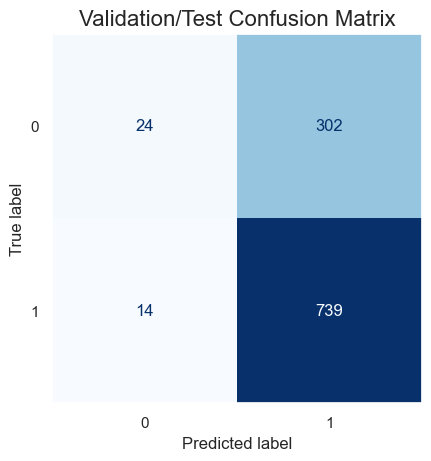

,Recall(Sensitivity) Train,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,,
LinearDiscriminantAnalysis,0.985055,0.071374,0.710249,0.528214,0.825379,0.981408,0.07362,0.709894,0.527514,0.823857


In [35]:
ML = "LinearDiscriminantAnalysis"
model_lda = fit.best_estimator_

# display the best model
print(f"\n{model_lda}\n")

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model_lda, X_train_scaled, y_train_arr, X_test_scaled, y_test_arr)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:, 2:]

### Performace Plots

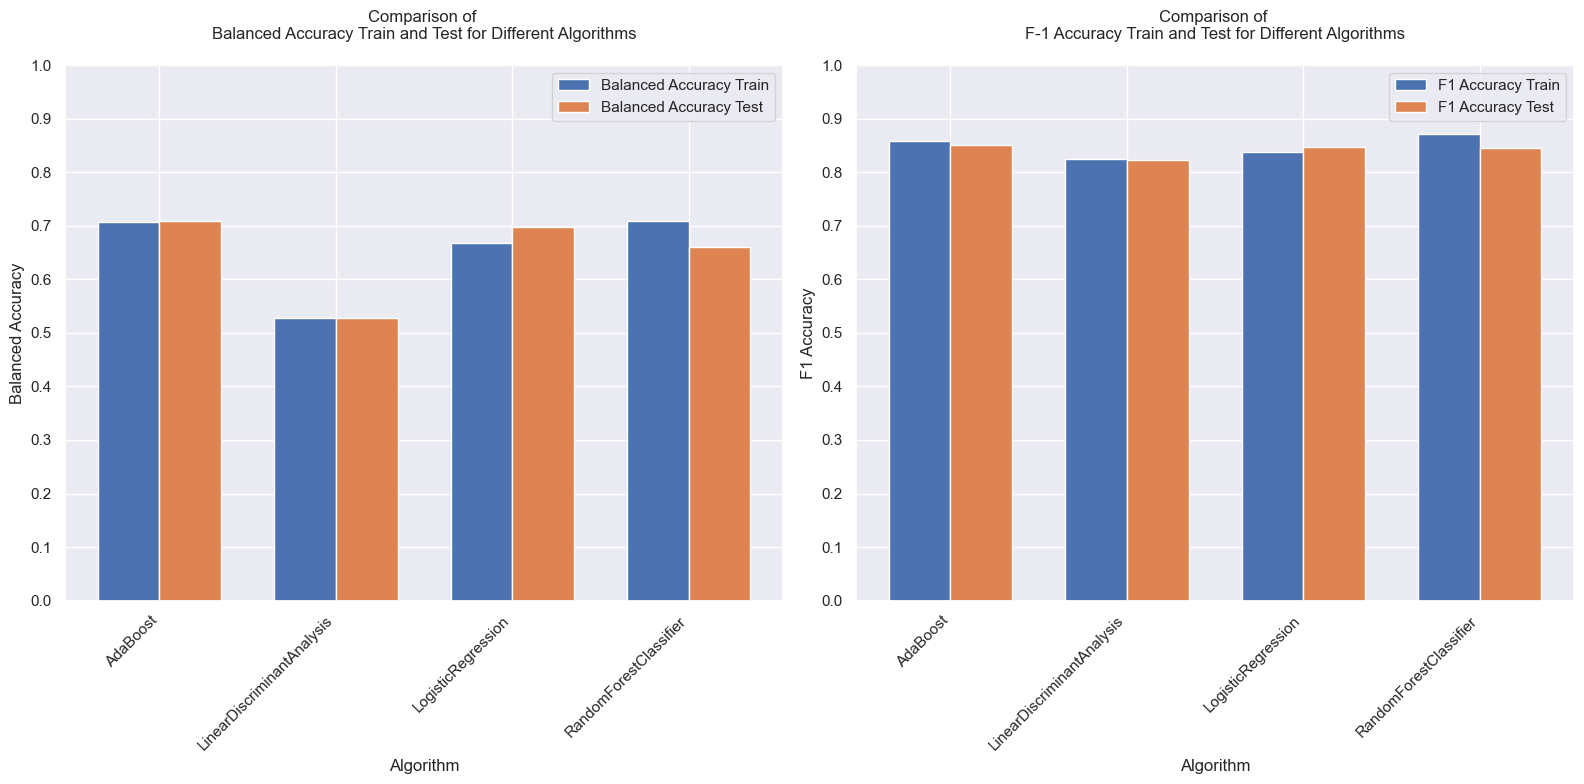

In [36]:
# display plots
plotBar(classify_performance_df, stage=0)

### ROC & Precision Recall Curve 

											Model=Random Forest Best Threshold=0.520, F-Score=0.898
											Model=AdaBoost Best Threshold=0.510, F-Score=0.903
											Model=LogisticRegression Best Threshold=0.505, F-Score=0.858
											Model=LDA Best Threshold=0.514, F-Score=0.837


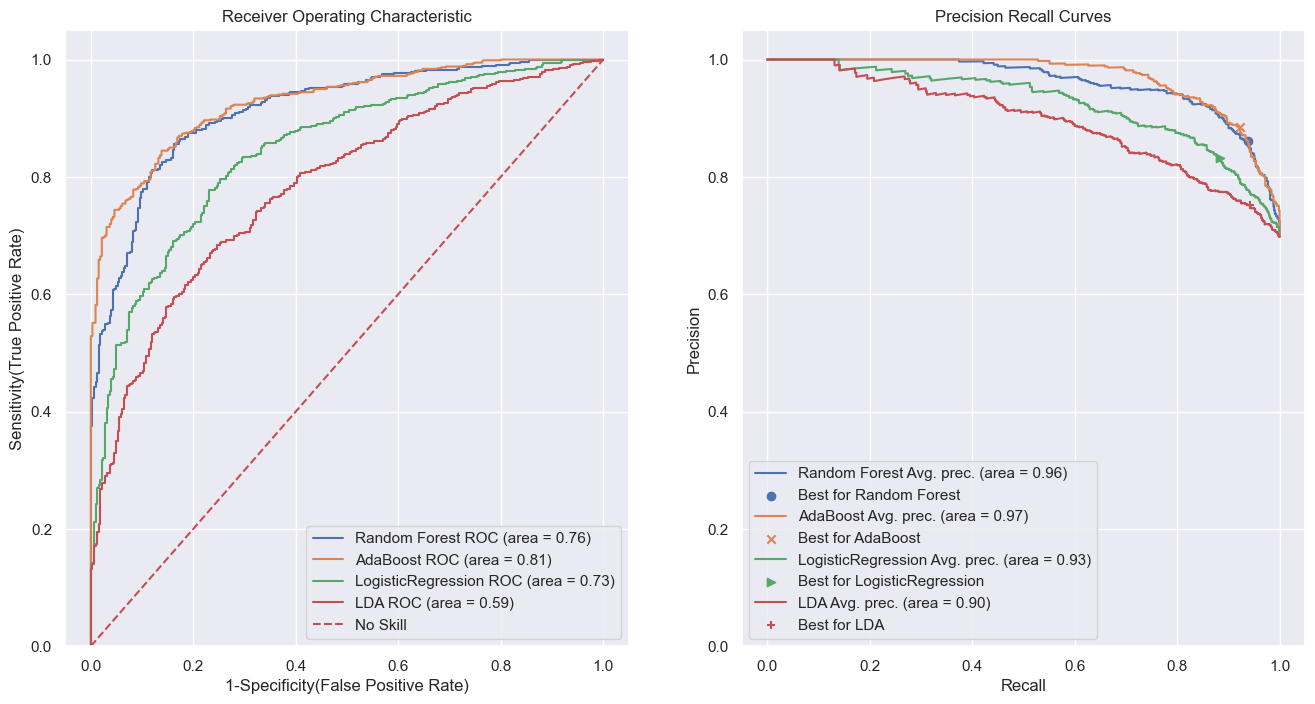

In [37]:
models = [{'label': 'Random Forest','marker': 'o','model':model_rfc,},{'label': 'AdaBoost','marker': 'x','model': model_adac,},{'label': 'LogisticRegression',
    'marker': '>','model': model_lrc,},{'label': 'LDA','marker': '+','model': model_lda,}]

# plot curves
Curve(models, X_test_scaled, y_test_arr) 

### Classfication Summary <a class='anchor' id="summary_full"></a>
- The metrics above show a clear difference in the `Balanced Accuracy Test` score with AdaBoost, and `F-1` is primarily similar for all the classifiers. From the above metrics report, AdaBoost is the best-performing model for our dataset since we are trying to predict whether a film will be profitable or successful. Let's use the `SelectKBest` feature selection using k=7, which was determined by feature importance from the Random Forest Classifier.

In [38]:
# display Over/Under sampling info
df = classify_performance_df
df.iloc[:, 3:]

,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,
LinearDiscriminantAnalysis,0.071374,0.710249,0.528214,0.825379,0.981408,0.073620,0.709894,0.527514,0.823857
AdaBoost,0.498081,0.808436,0.707360,0.859144,0.895086,0.521472,0.812048,0.708279,0.851548
LogisticRegression,0.438987,0.786943,0.667850,0.838249,0.893758,0.503067,0.805988,0.698413,0.847607
RandomForestClassifier,0.470453,0.805305,0.709155,0.870786,0.922975,0.398773,0.780022,0.660874,0.845499


### SelectKBest Feature Selection <a class='anchor' id="kbest"></a>
- Use the percent of feature importance greater than 5% from Random Forest to re-evaluate our model and determine its performance. Finally, let's use `feature_selection.SelectKBest` with `feature_selection.f_classif` and `k = 7` for our dataset for comparison with our best performing model.

In [39]:
# feature selection: k = 7
k_best = feature_selection.SelectKBest(score_func=feature_selection.f_classif, k=7)
# fit and transform train
X_train_selected = k_best.fit_transform(X_train_scaled, y_train_arr)
# transform test
X_test_selected = k_best.transform(X_test_scaled)

### AdaBoost with SelectKBest <a class='anchor' id="adakbest"></a>
- In conclusion, our dataset's feature space needs to be wider to warrant dimensionality reduction, and a loss of $\approx$1 % in balanced accuracy but we will examine over/under sampling since our dataset has some imbalance.

In [40]:
# hyper-parameters AdaBoost
# number of trees in the forest (default (50))
n_estimators = list(np.linspace(10, 100, num=4, dtype=np.intc))
# learning rate default(1)
learning_rate = np.round(np.logspace(-2, 0.2 , 4), 2)

# define the parameter grid for AdaBoostClassifier and the base DecisionTreeClassifier
parameters = {
    # Decision Tree tuning
    'estimator__max_depth': [3, 5, 7],
    'estimator__criterion': ['gini','entropy'],
    'estimator__min_samples_split': [5, 10, 15],
    # AdaBoost Tuning
    'n_estimators': n_estimators,  # Number of boosting stages
    'learning_rate': learning_rate,  # Weight applied to each classifier at each boosting iteration
}

# create DecisionTreeClassifier as estimator (weak learner)
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Base Model
ada_param = {'estimator': dtc, 'algorithm':'SAMME', 'random_state': RANDOM_STATE}

# instantiate AdaBoost Classifier
model = AdaBoostClassifier(**ada_param)

# CV with grid search for Hyper-Parameter tuning use Z-Score
fit =  kfold_grid(model, parameters, X_train_selected, y_train_arr)

CV accuracy: 0.802 +/- 0.030



AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_split=5,
                                                    random_state=1776),
                   learning_rate=0.29, n_estimators=100, random_state=1776)

***** Classfication Metrics for Training:
Recall (Sensitivity):   0.8927
Specificity:            0.5388
Precision:              0.8173
Balanced Accuracy:      0.7157
F1 Score:               0.8533




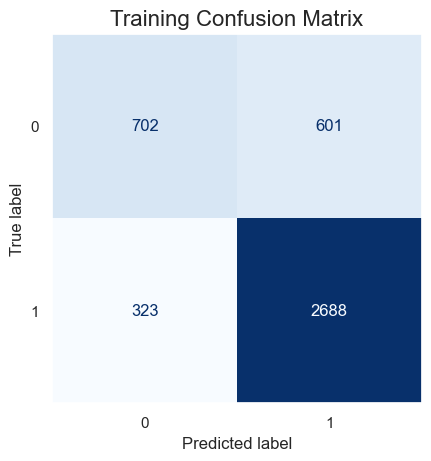



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.8818
Specificity:            0.5153
Precision:              0.8078
Balanced Accuracy:      0.6986
F1 Score:               0.8432




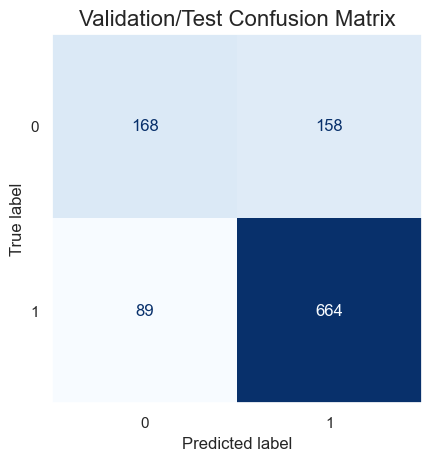

,Recall(Sensitivity) Train,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,,
AdaBoost:SelectKBest,0.892727,0.538757,0.81727,0.715742,0.853333,0.881806,0.515337,0.807786,0.698572,0.843175


In [41]:
# initialize
ML = "AdaBoost:SelectKBest"
model_ada_fs = fit.best_estimator_

# display the best model
print(f"\n{model_ada_fs}\n")

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model_ada_fs, X_train_selected, y_train_arr, X_test_selected, y_test_arr)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:,2:]

### Random Forest Tuning for Stacking <a class='anchor' id="stack_tune"></a>

In [42]:
# instantiate Model
rfc = dict(n_estimators=10, random_state = RANDOM_STATE)
# instantiate RandomForest Classifier
model = RandomForestClassifier(**rfc)

min_samples_leaf = 1 Train = 0.9907793758258532 Test = 0.7415350820658246
min_samples_leaf = 2 Train = 0.9562922529320066 Test = 0.7382911188450632
min_samples_leaf = 3 Train = 0.9223202288791563 Test = 0.7475503781043222
min_samples_leaf = 4 Train = 0.8970532923138324 Test = 0.7549765833118501
min_samples_leaf = 5 Train = 0.8788439163937761 Test = 0.7517283234510612


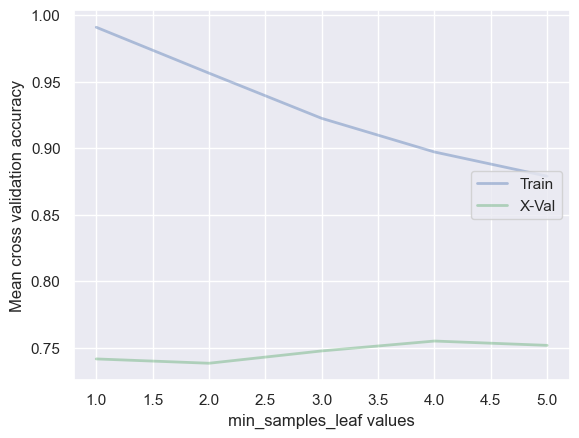

In [43]:
# let's check min_samples_leaf with 10 fold CV
msl = range(1,6)
calc_params(X_train_scaled, y_train_arr, model, msl, 'min_samples_leaf', 10)

max_depth = 1 Train = 0.6979600854606438 Test = 0.6979594196040898
max_depth = 2 Train = 0.7007997413213897 Test = 0.6979599573064339
max_depth = 3 Train = 0.7070583265871179 Test = 0.7018997023817525
max_depth = 4 Train = 0.7291955780194366 Test = 0.7167351789070124
max_depth = 5 Train = 0.7546937878519769 Test = 0.7313362172102389
max_depth = 6 Train = 0.7748027256613278 Test = 0.7438528523765099
max_depth = 7 Train = 0.7946223960475628 Test = 0.7464050565528442
max_depth = 8 Train = 0.8077190080091652 Test = 0.7487209405489403
max_depth = 9 Train = 0.8271903654976995 Test = 0.7521987993106657
max_depth = 10 Train = 0.8419097290892223 Test = 0.7573010568539573


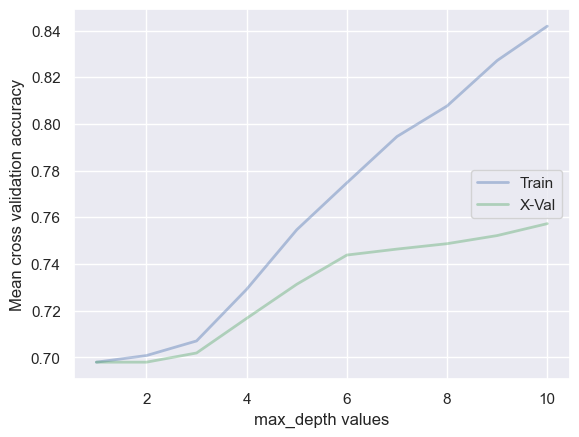

In [44]:
# let's check max_depth with 10 fold CV
m_depth = [1,2,3,4,5,6,7,8,9,10]
calc_params(X_train_scaled, y_train_arr, model, m_depth, 'max_depth', 5)

n_estimators = 5 Train = 0.8211505043915253 Test = 0.7459326931339693
n_estimators = 10 Train = 0.8344405852111935 Test = 0.7507975638051045
n_estimators = 15 Train = 0.8390252667441785 Test = 0.7593741943799949
n_estimators = 20 Train = 0.8432493359673063 Test = 0.75914217581851
n_estimators = 25 Train = 0.8463141624616902 Test = 0.7619296210363495
n_estimators = 30 Train = 0.8470611204628744 Test = 0.7600729354644667
n_estimators = 35 Train = 0.8493018551519107 Test = 0.7633185099252385
n_estimators = 40 Train = 0.8489155492647311 Test = 0.7614650468333763
n_estimators = 45 Train = 0.8498943465240298 Test = 0.7635532138867406
n_estimators = 50 Train = 0.8519549210066787 Test = 0.7603054911059551
n_estimators = 55 Train = 0.8514911960522777 Test = 0.7621621766778378
n_estimators = 60 Train = 0.8517744821712577 Test = 0.7614698805534073
n_estimators = 65 Train = 0.8523668209608111 Test = 0.7630923992437915
n_estimators = 70 Train = 0.8527532661625074 Test = 0.7623984918793504
n_estimat

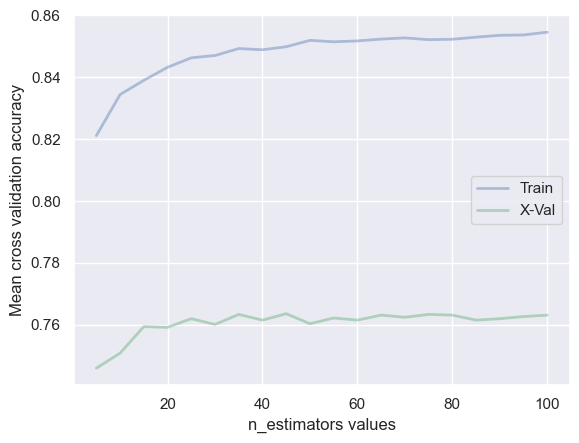

In [45]:
# let's check n_estimators with 10 fold CV
nest = range(5, 101, 5)
calc_params(X_train_scaled, y_train_arr, model, nest, 'n_estimators', 10)

### Stacking RandomForest & AdaBoost with  Meta Model of LogisticRegression <a class='anchor' id="stacking"></a>

In [46]:
# define base models
base_models = [
    ('rf', RandomForestClassifier(min_samples_leaf=4, max_depth=8, n_estimators=80,random_state=RANDOM_STATE)),
    ('ada', AdaBoostClassifier(algorithm='SAMME',random_state=RANDOM_STATE))
]

# define meta-model
meta_model = LogisticRegression(random_state=RANDOM_STATE)

# create StackingClassifier
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# train StackingClassifier
stacking_classifier.fit(X_train_scaled, y_train_arr)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=8,
                                                       min_samples_leaf=4,
                                                       n_estimators=80,
                                                       random_state=1776)),
                               ('ada',
                                AdaBoostClassifier(algorithm='SAMME',
                                                   random_state=1776))],
                   final_estimator=LogisticRegression(random_state=1776))


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=8,
                                                       min_samples_leaf=4,
                                                       n_estimators=80,
                                                       random_state=1776)),
                               ('ada',
                                AdaBoostClassifier(algorithm='SAMME',
                                                   random_state=1776))],
                   final_estimator=LogisticRegression(random_state=1776))

***** Classfication Metrics for Training:
Recall (Sensitivity):   0.9229
Specificity:            0.6002
Precision:              0.8421
Balanced Accuracy:      0.7616
F1 Score:               0.8807




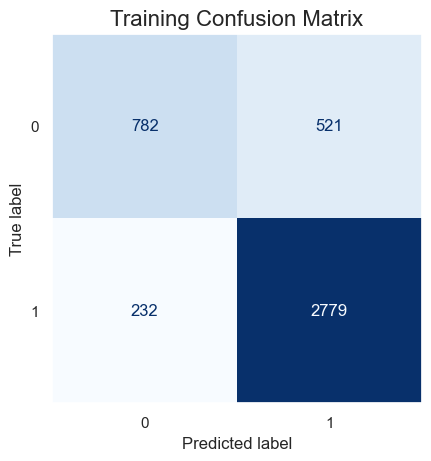



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.8991
Specificity:            0.5184
Precision:              0.8118
Balanced Accuracy:      0.7087
F1 Score:               0.8532




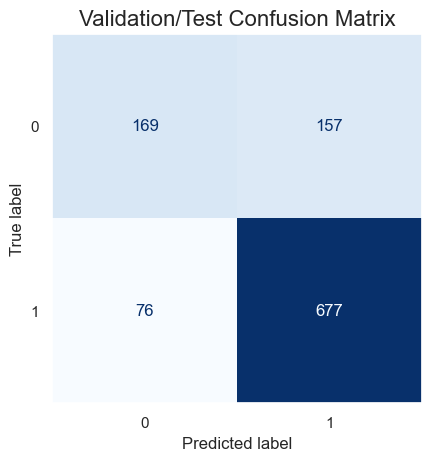

,Recall(Sensitivity) Train,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,,
StackingClassifier:TuneRFC,0.922949,0.600153,0.842121,0.761551,0.880685,0.89907,0.518405,0.811751,0.708738,0.853182


In [47]:
ML = "StackingClassifier:TuneRFC"
model_clf = stacking_classifier

# display the best model
print(f"\n{model_clf}\n")

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model_clf, X_train_scaled, y_train_arr, X_test_scaled, y_test_arr)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:, 2:]

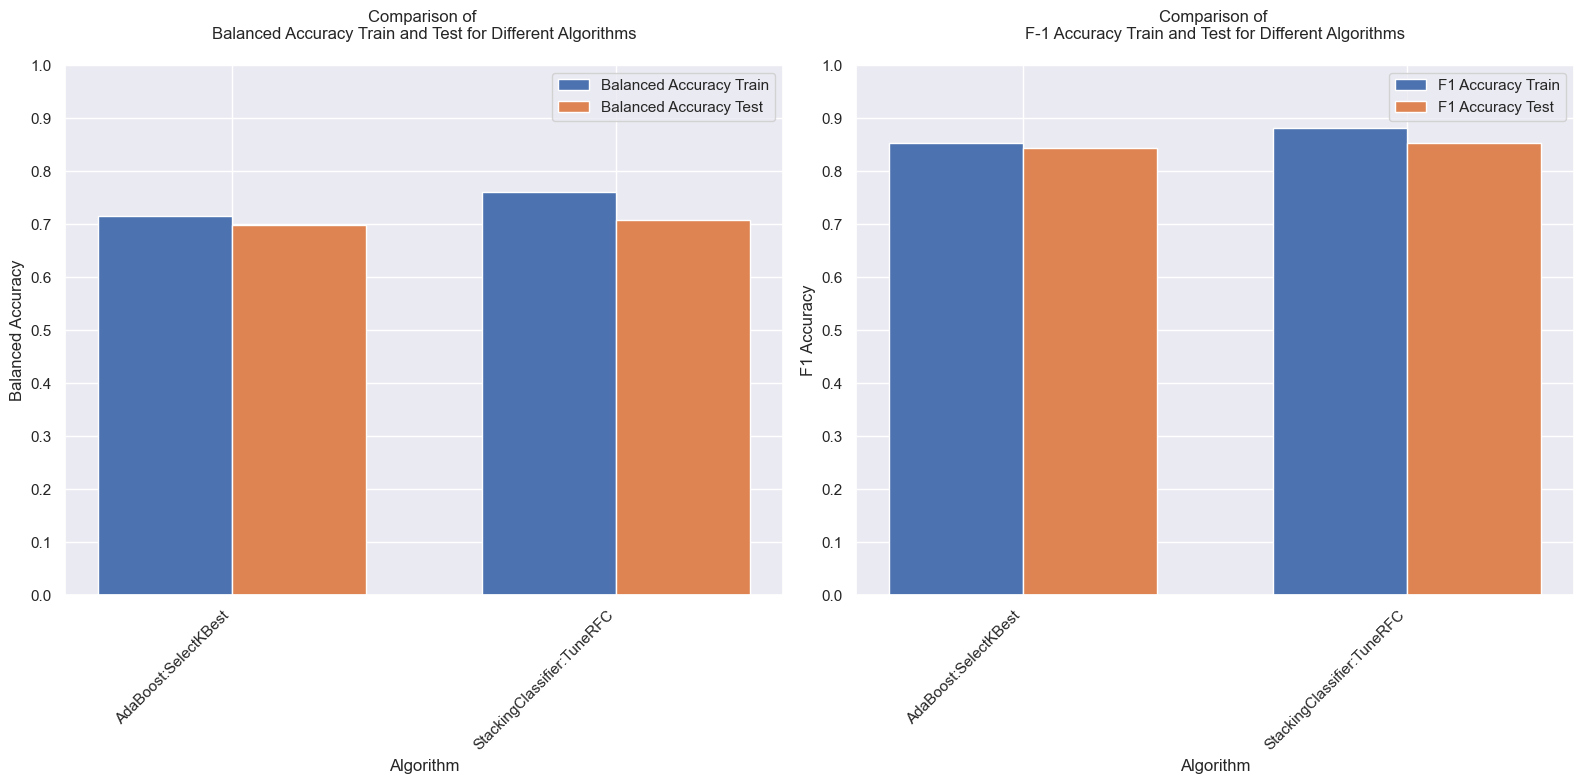

In [48]:
# display plots
plotBar(classify_performance_df, stage=1)

											Model=AdaBoost:KBest Best Threshold=0.501, F-Score=0.941
											Model=StackingClassifier Best Threshold=0.499, F-Score=0.927


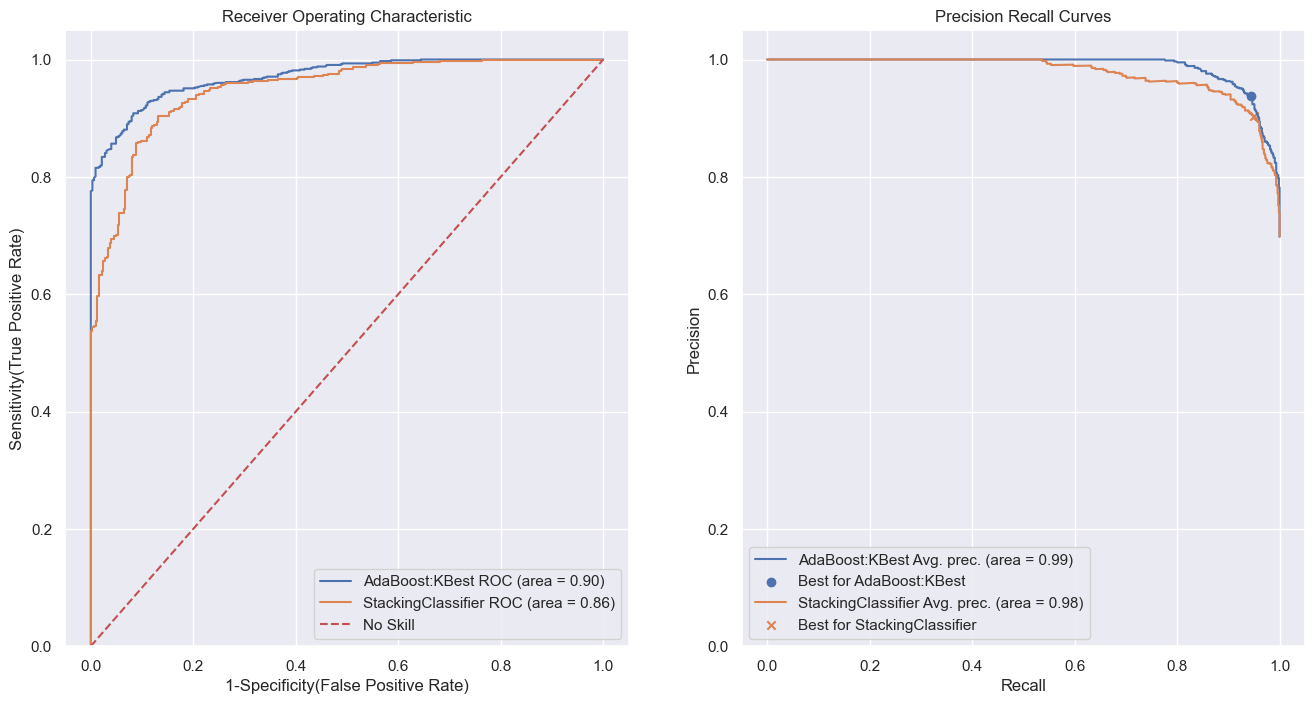

In [49]:
modelsSKB = [{'label': 'AdaBoost:KBest','marker': 'o','model': model_ada_fs,},{'label': 'StackingClassifier','marker': 'x','model': model_clf,},]

# plot curves
Curve(modelsSKB, X_test_scaled, y_test_arr) 

In [50]:
# display Over/Under sampling info
df = classify_performance_df[classify_performance_df.index.str.contains(":")]
df.iloc[:, 3:]

,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,
StackingClassifier:TuneRFC,0.600153,0.842121,0.761551,0.880685,0.899070,0.518405,0.811751,0.708738,0.853182
AdaBoost:SelectKBest,0.538757,0.817270,0.715742,0.853333,0.881806,0.515337,0.807786,0.698572,0.843175


### Sampling <a class='anchor' id="sampling"></a>
-  We will experiment with over-sampling with `SMOTE` and undersampling with `RandomUnderSampler` to determine whether there are any performance improvements.

In [51]:
# sampling libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [52]:
# instantiate smote for continuous and categorical features oversample
overSample = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE, k_neighbors=3)

# over sample training before scaling
X_over, y_over = overSample.fit_resample(X_train, y_train_arr)

# instantiate smote for continuous and categorical features undersample
underSample = RandomUnderSampler(sampling_strategy='majority', random_state=RANDOM_STATE)

# under sample training
X_under, y_under = underSample.fit_resample(X_train, y_train_arr)

In [53]:
# display shape and vertify y_over is balanced
X_over.shape, y_over.shape, np.unique(y_over, return_counts=True)

((6022, 15), (6022,), (array([0, 1]), array([3011, 3011])))

In [54]:
# display shape and vertify y_under is balanced
X_under.shape, y_under.shape, np.unique(y_under, return_counts=True)

((2606, 15), (2606,), (array([0, 1]), array([1303, 1303])))

In [55]:
# change to array
X_over_arr = X_over.values
X_under_arr = X_under.values

# shape
X_over_arr.shape, X_under_arr.shape

((6022, 15), (2606, 15))

In [56]:
# instantiate scale
scaleSampling = StandardScaler()

# fit_transform over sample
X_over_scaled = scaleSampling.fit_transform(X_over_arr)

# fit_transform under sample
X_under_scaled = scaleSampling.fit_transform(X_under_arr)

### Random Forest Classifier: OverSampling <a class='anchor' id="rfc_over"></a>

The random forest classifier (RFC) is the best-performing model in the over-sampled dataset regarding both `Balanced Accuracy` and `F-1` scores. RFC may be on the verge of overfitting and should fine-tune the Hyperparameters. According to the training and test dataset, AdaBoost is performing much better in terms of `F-1` scores than the Logistic Regression.

In [57]:
# define the hyperparameter grid to search
parameters = dict(
# minimum number of samples required to split a node
min_samples_split = list(np.linspace(30, 60, num=4, dtype=np.intc)),
# maximum number of levels in tree
max_depth = list(np.linspace(6,20, num=4, dtype=np.intc)), 
# number of trees in the forest
n_estimators = list(np.linspace(10, 150, num=4, dtype=np.intc)),
# function to measure the quality of a split
criterion = ['gini', 'entropy'],
)

# # instantiate Model
rfc_param = {'random_state': RANDOM_STATE}

# instantiate RandomForest Classifier
model = RandomForestClassifier(**rfc_param)

# CV with grid search for Hyper-Parameter tuning
fit = kfold_grid(model, parameters, X_over_scaled, y_over)

CV accuracy: 0.880 +/- 0.010



RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_split=30,
                       n_estimators=150, random_state=1776)

***** Classfication Metrics for Training:
Recall (Sensitivity):   0.8731
Specificity:            0.9057
Precision:              0.9025
Balanced Accuracy:      0.8894
F1 Score:               0.8876




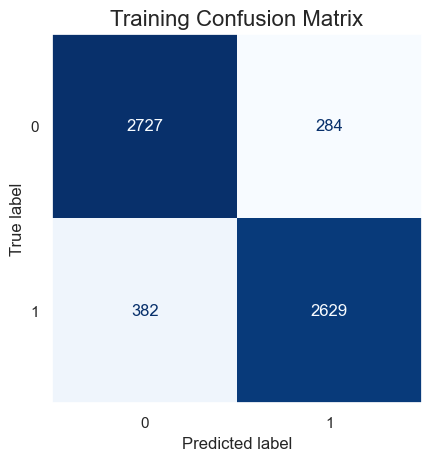



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.7224
Specificity:            0.8160
Precision:              0.9007
Balanced Accuracy:      0.7692
F1 Score:               0.8018




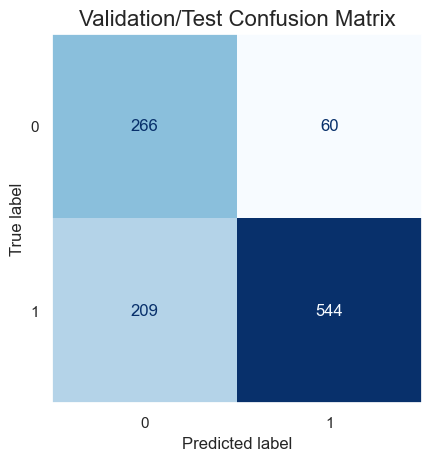



                       % Feature Importance
vote_count                        26.465815
belongs_to_collection             11.850387
budget                            11.308307
popularity                        10.897458
runtime                            7.256567
cast_size                          6.118096
crew_size                          5.734377
release_quarter                    4.290529
production_companies               3.250840
is_Holiday                         3.017262
genres                             2.656105
spoken_languages                   2.209676
is_Friday                          2.061308
production_countries               2.025747
is_english                         0.857526


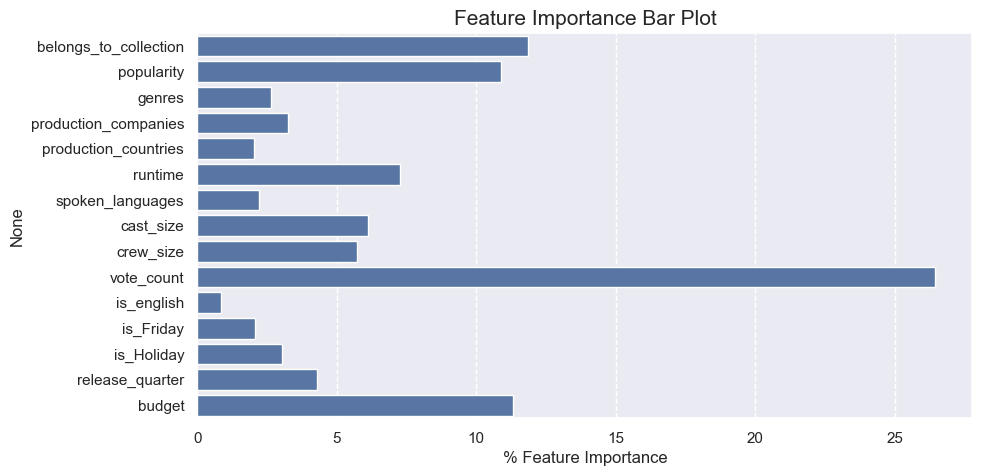

,Recall(Sensitivity) Train,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,,
RandomForestClassifier-OverSample,0.873132,0.905679,0.902506,0.889406,0.887576,0.722444,0.815951,0.900662,0.769197,0.801769


In [58]:
ML = "RandomForestClassifier-OverSample"
model_rfc_over = fit.best_estimator_

# display the best model
print(f"\n{model_rfc_over}\n")

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model_rfc_over, X_over_scaled, y_over, X_test_scaled, y_test_arr)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

# feature importance
plot_feature_importance(model_rfc_over, clean)

df_.iloc[:, 2:]

### Logistic Regression - OverSampling  <a class='anchor' id="lrc_over"></a>

In [59]:
# define the hyperparameter grid to search
parameters = dict(
C = np.linspace(0.15, 5, 15),
max_iter = list(np.linspace(50, 300, num=5, dtype=np.intc)),
class_weight = ['balanced', None],
)
# Base Model
lr_param = {'random_state': RANDOM_STATE}

# instantiate Logistic Regression
model = LogisticRegression(**lr_param)

# CV with grid search for Hyper-Parameter tuning
fit = kfold_grid(model, parameters, X_over_scaled, y_over)

CV accuracy: 0.836 +/- 0.010



LogisticRegression(C=5.0, class_weight='balanced', max_iter=50,
                   random_state=1776)

***** Classfication Metrics for Training:
Recall (Sensitivity):   0.6652
Specificity:            0.8393
Precision:              0.8054
Balanced Accuracy:      0.7522
F1 Score:               0.7286




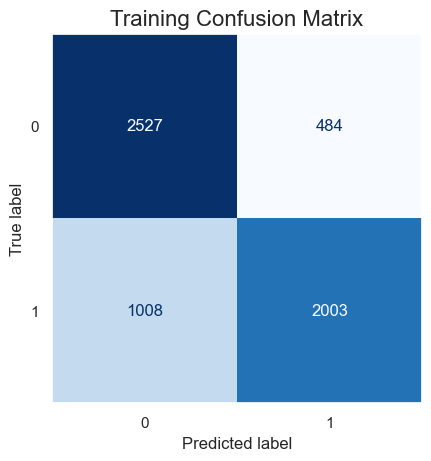



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.5817
Specificity:            0.8834
Precision:              0.9202
Balanced Accuracy:      0.7326
F1 Score:               0.7128




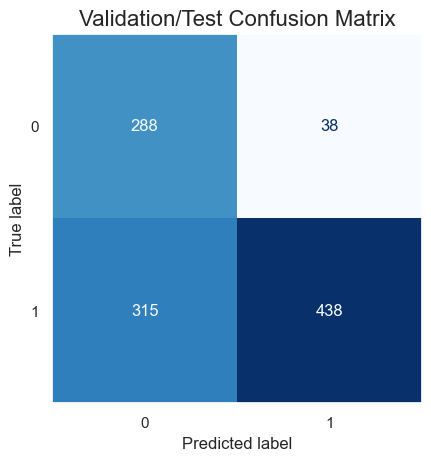

,Recall(Sensitivity) Train,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,,
LogisticRegression-OverSample,0.665227,0.839256,0.805388,0.752242,0.728629,0.581673,0.883436,0.920168,0.732554,0.712775


In [60]:
ML = "LogisticRegression-OverSample"
model_lrc_over = fit.best_estimator_

# display the best model
print(f"\n{model_lrc_over}\n")

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model_lrc_over, X_over_scaled, y_over, X_test_scaled, y_test_arr)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:, 2:]

### AdaBoost Classifier - OverSampling  <a class='anchor' id="adac_over"></a>

In [61]:
# hyper-parameters AdaBoost
# number of trees in the forest (default (50))
n_estimators = list(np.linspace(10, 100, num=4, dtype=np.intc))
# learning rate default(1)
learning_rate = np.round(np.logspace(-2, 0.2 , 4), 2)

# Define the parameter grid for AdaBoostClassifier and the base DecisionTreeClassifier
parameters = {
    # Decision Tree tuning
    'estimator__max_depth': [3, 5],
    'estimator__criterion': ['gini','entropy'],
    'estimator__min_samples_split': [15, 30],
    # AdaBoost Tuning
    'n_estimators': n_estimators,  # Number of boosting stages
    'learning_rate': learning_rate,  # Weight applied to each classifier at each boosting iteration
}

# create DecisionTreeClassifier as estimator (weak learner)
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Base Model
ada_param = {'estimator': dtc, 'algorithm':'SAMME', 'random_state': RANDOM_STATE}

# instantiate AdaBoost Classifier
model = AdaBoostClassifier(**ada_param)

# CV with grid search for Hyper-Parameter tuning
fit =  kfold_grid(model, parameters, X_over_scaled, y_over)

CV accuracy: 0.875 +/- 0.009



AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=5,
                                                    min_samples_split=30,
                                                    random_state=1776),
                   learning_rate=0.29, n_estimators=100, random_state=1776)

***** Classfication Metrics for Training:
Recall (Sensitivity):   0.7702
Specificity:            0.8406
Precision:              0.8285
Balanced Accuracy:      0.8054
F1 Score:               0.7983




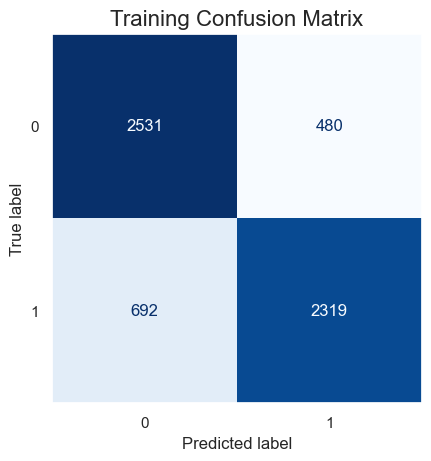



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.6720
Specificity:            0.8252
Precision:              0.8988
Balanced Accuracy:      0.7486
F1 Score:               0.7690




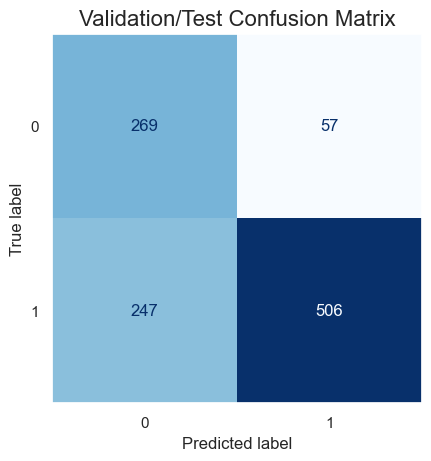

,Recall(Sensitivity) Train,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,,
AdaBoost-OverSample,0.770176,0.840585,0.82851,0.80538,0.798279,0.671979,0.825153,0.898757,0.748566,0.768997


In [62]:
# initialize
ML = "AdaBoost-OverSample"
model_ada_over = fit.best_estimator_

# display the best model
print(f"\n{model_ada_over}\n")

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model_ada_over, X_over_scaled, y_over, X_test_scaled, y_test_arr)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:,2:]

In [63]:
# display Over/Under sampling info
df = classify_performance_df[classify_performance_df.index.str.contains("-Over")]
df.iloc[:, 3:]

,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,
AdaBoost-OverSample,0.840585,0.828510,0.805380,0.798279,0.671979,0.825153,0.898757,0.748566,0.768997
LogisticRegression-OverSample,0.839256,0.805388,0.752242,0.728629,0.581673,0.883436,0.920168,0.732554,0.712775
RandomForestClassifier-OverSample,0.905679,0.902506,0.889406,0.887576,0.722444,0.815951,0.900662,0.769197,0.801769


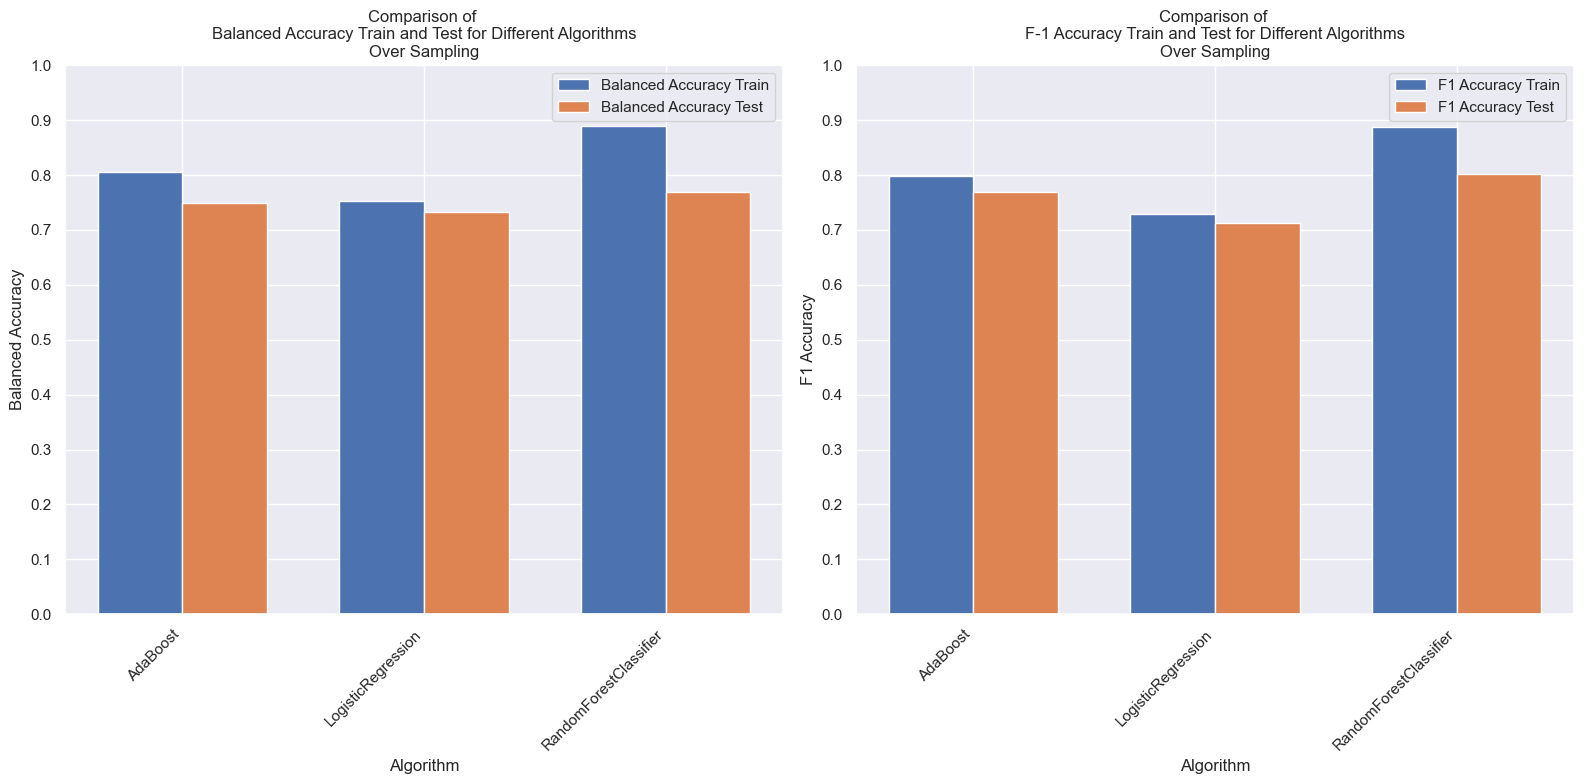

In [64]:
# display plots
plotBar(classify_performance_df, stage=2)

### Over Sampling Calssfication Summary <a class='anchor' id="over_summary"></a>
- There is overfitting in Random Forest model, as evidenced by the $\approx$11% drop in Balanced Accuracy from the training set to the test set. Hyperparameter tuning may improve the performance of these models further, especially in mitigating overfitting issues. Interestingly, Logistic Regression has a performance increase $\approx$3%, and the model looks useful. AdaBoost performance did have wider gap in sampled data.

### Random Forest Classifier - UnderSampling <a class='anchor' id="rfc_under"></a>

In [65]:
# define the hyperparameter grid to search
parameters = dict(
# minimum number of samples required to split a node
min_samples_split = list(np.linspace(15, 30, num=3, dtype=np.intc)),
# maximum number of levels in tree
max_depth = list(np.linspace(6, 10, num=3, dtype=np.intc)), 
# number of trees in the forest
n_estimators = list(np.linspace(50, 150, num=3, dtype=np.intc)),
# function to measure the quality of a split
criterion = ['gini', 'entropy'],
)

# # instantiate Model
rfc_param = {'random_state': RANDOM_STATE}

# instantiate RandomForest Classifier
model = RandomForestClassifier(**rfc_param)

# CV with grid search for Hyper-Parameter tuning
fit = kfold_grid(model, parameters, X_under_scaled, y_under)

CV accuracy: 0.807 +/- 0.031



RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=22,
                       n_estimators=150, random_state=1776)

***** Classfication Metrics for Training:
Recall (Sensitivity):   0.7874
Specificity:            0.8864
Precision:              0.8739
Balanced Accuracy:      0.8369
F1 Score:               0.8284




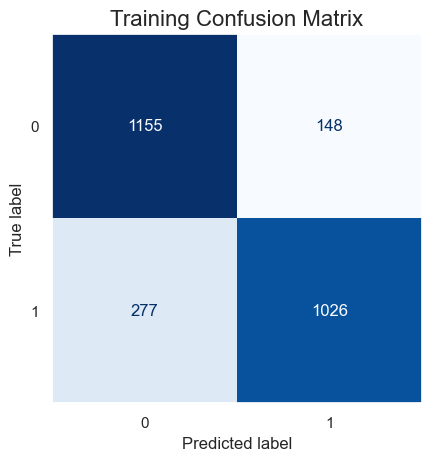



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.5737
Specificity:            0.8957
Precision:              0.9270
Balanced Accuracy:      0.7347
F1 Score:               0.7088




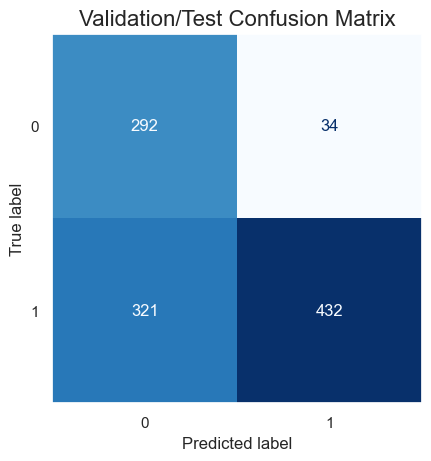



                       % Feature Importance
vote_count                        32.349021
popularity                        13.018417
budget                            10.716402
belongs_to_collection              7.723644
runtime                            7.503868
cast_size                          7.125752
crew_size                          6.060226
production_companies               4.522200
production_countries               2.911171
genres                             2.500614
spoken_languages                   1.764873
release_quarter                    1.515684
is_english                         0.987056
is_Friday                          0.754193
is_Holiday                         0.546881


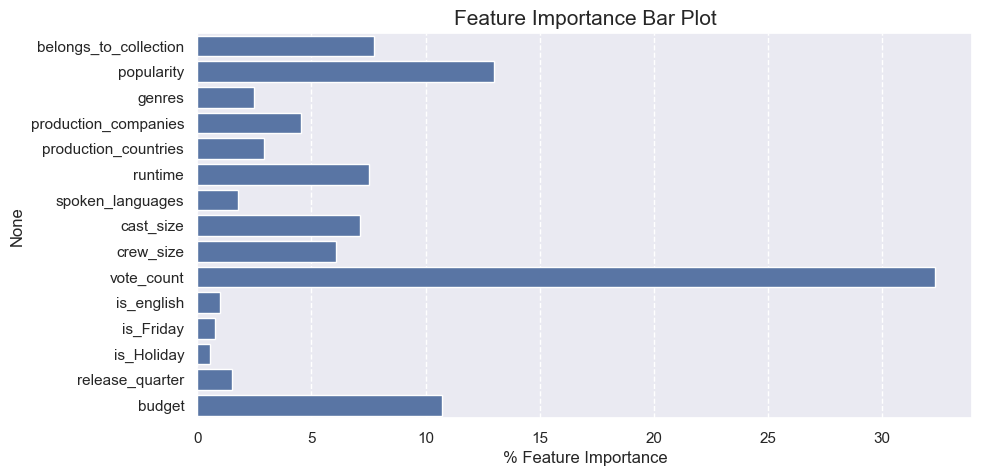

,Recall(Sensitivity) Train,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,,
RandomForestClassifier-UnderSample,0.787414,0.886416,0.873935,0.836915,0.828421,0.573705,0.895706,0.927039,0.734705,0.708778


In [66]:
ML = "RandomForestClassifier-UnderSample"
model_rfc_under = fit.best_estimator_

# display the best model
print(f"\n{model_rfc_under}\n")

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model_rfc_under, X_under_scaled, y_under, X_test_scaled, y_test_arr)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

# feature importance
plot_feature_importance(model_rfc_under, clean)

df_.iloc[:, 2:]

### Logistic Regression - UnderSampling  <a class='anchor' id="lrc_under"></a>

In [67]:
# define the hyperparameter grid to search
parameters = dict(
C = np.round(np.linspace(0.15, 5, 15),2),
max_iter = list(np.linspace(50, 300, num=5, dtype=np.intc)),
class_weight = ['balanced', None],
)
# Base Model
lr_param = {'random_state': RANDOM_STATE}

# instantiate Logistic Regression
model = LogisticRegression(**lr_param)

# CV with grid search for Hyper-Parameter tuning
fit = kfold_grid(model, parameters, X_under_scaled, y_under)

CV accuracy: 0.798 +/- 0.026



LogisticRegression(C=5.0, class_weight='balanced', max_iter=50,
                   random_state=1776)

***** Classfication Metrics for Training:
Recall (Sensitivity):   0.6255
Specificity:            0.8243
Precision:              0.7807
Balanced Accuracy:      0.7249
F1 Score:               0.6945




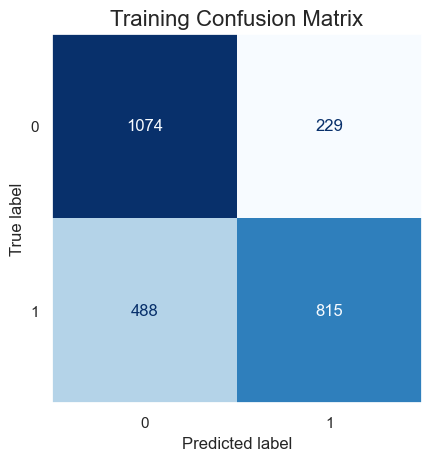



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.5578
Specificity:            0.9294
Precision:              0.9481
Balanced Accuracy:      0.7436
F1 Score:               0.7023




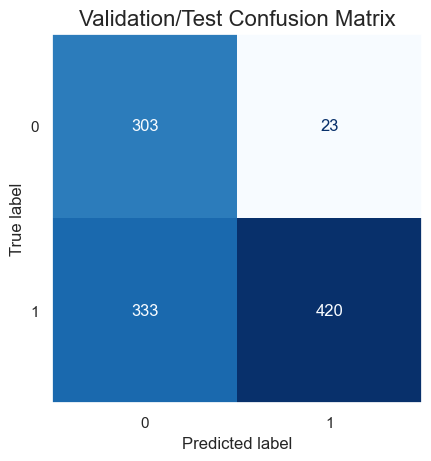

,Recall(Sensitivity) Train,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,,
LogisticRegression-UnderSample,0.62548,0.824252,0.780651,0.724866,0.694504,0.557769,0.929448,0.948081,0.743608,0.702341


In [68]:
ML = "LogisticRegression-UnderSample"
model_lrc_under = fit.best_estimator_

# display the best model
print(f"\n{model_lrc_under}\n")

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model_lrc_under, X_under_scaled, y_under, X_test_scaled, y_test_arr)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:, 2:]

### AdaBoost Classifier - UnderSampling  <a class='anchor' id="adac_under"></a>

In [69]:
# hyper-parameters AdaBoost
# number of trees in the forest (default (50))
n_estimators = list(np.linspace(10, 100, num=4, dtype=np.intc))
# learning rate default(1)
learning_rate = np.round(np.logspace(-2, 0.2 , 4), 2)

# Define the parameter grid for AdaBoostClassifier and the base DecisionTreeClassifier
parameters = {
    # Decision Tree tuning
    'estimator__max_depth': [5, 7],
    'estimator__criterion': ['gini','entropy'],
    'estimator__min_samples_split': [10, 15],
    # AdaBoost Tuning
    'n_estimators': n_estimators,  # Number of boosting stages
    'learning_rate': learning_rate,  # Weight applied to each classifier at each boosting iteration
}

# create DecisionTreeClassifier as estimator (weak learner)
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Base Model
ada_param = {'estimator': dtc, 'algorithm':'SAMME', 'random_state': RANDOM_STATE}

# instantiate AdaBoost Classifier
model = AdaBoostClassifier(**ada_param)

# CV with grid search for Hyper-Parameter tuning
fit =  kfold_grid(model, parameters, X_under_scaled, y_under)

CV accuracy: 0.807 +/- 0.027



AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=5,
                                                    min_samples_split=15,
                                                    random_state=1776),
                   learning_rate=0.05, n_estimators=70, random_state=1776)

***** Classfication Metrics for Training:
Recall (Sensitivity):   0.6899
Specificity:            0.8327
Precision:              0.8048
Balanced Accuracy:      0.7613
F1 Score:               0.7430




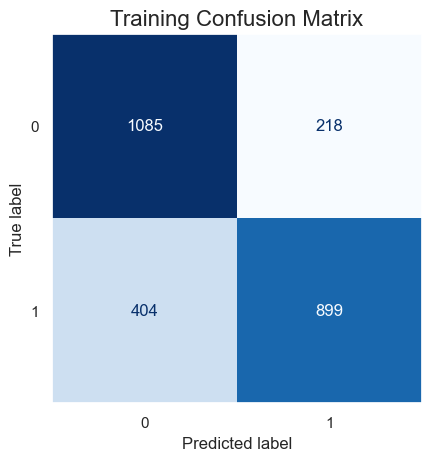



***** Classfication Metrics for Validation/Test:
Recall (Sensitivity):   0.5710
Specificity:            0.8957
Precision:              0.9267
Balanced Accuracy:      0.7334
F1 Score:               0.7067




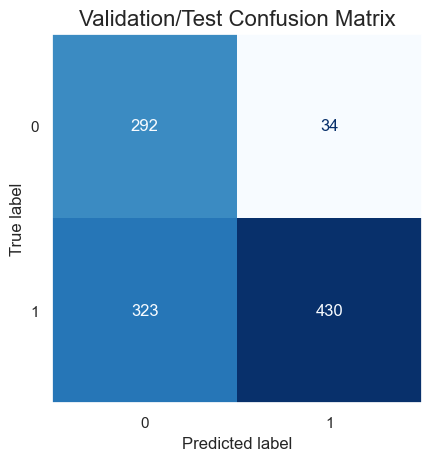

,Recall(Sensitivity) Train,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,,
AdaBoost-UnderSample,0.689946,0.832694,0.804834,0.76132,0.742975,0.571049,0.895706,0.926724,0.733377,0.706656


In [70]:
# initialize
ML = "AdaBoost-UnderSample"
model_ada_under = fit.best_estimator_

# display the best model
print(f"\n{model_ada_under}\n")

# update dictionary to track performace
df_ = classifier_performance_dict(ML, model_ada_under, X_under_scaled, y_under, X_test_scaled, y_test_arr)

# concat current with historical
classify_performance_df = pd.concat([df_, classify_performance_df])

df_.iloc[:,2:]

In [71]:
# display Over/Under sampling info
df = classify_performance_df[classify_performance_df.index.str.contains("-Under")]
df.iloc[:, 3:]

,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,
AdaBoost-UnderSample,0.832694,0.804834,0.761320,0.742975,0.571049,0.895706,0.926724,0.733377,0.706656
LogisticRegression-UnderSample,0.824252,0.780651,0.724866,0.694504,0.557769,0.929448,0.948081,0.743608,0.702341
RandomForestClassifier-UnderSample,0.886416,0.873935,0.836915,0.828421,0.573705,0.895706,0.927039,0.734705,0.708778


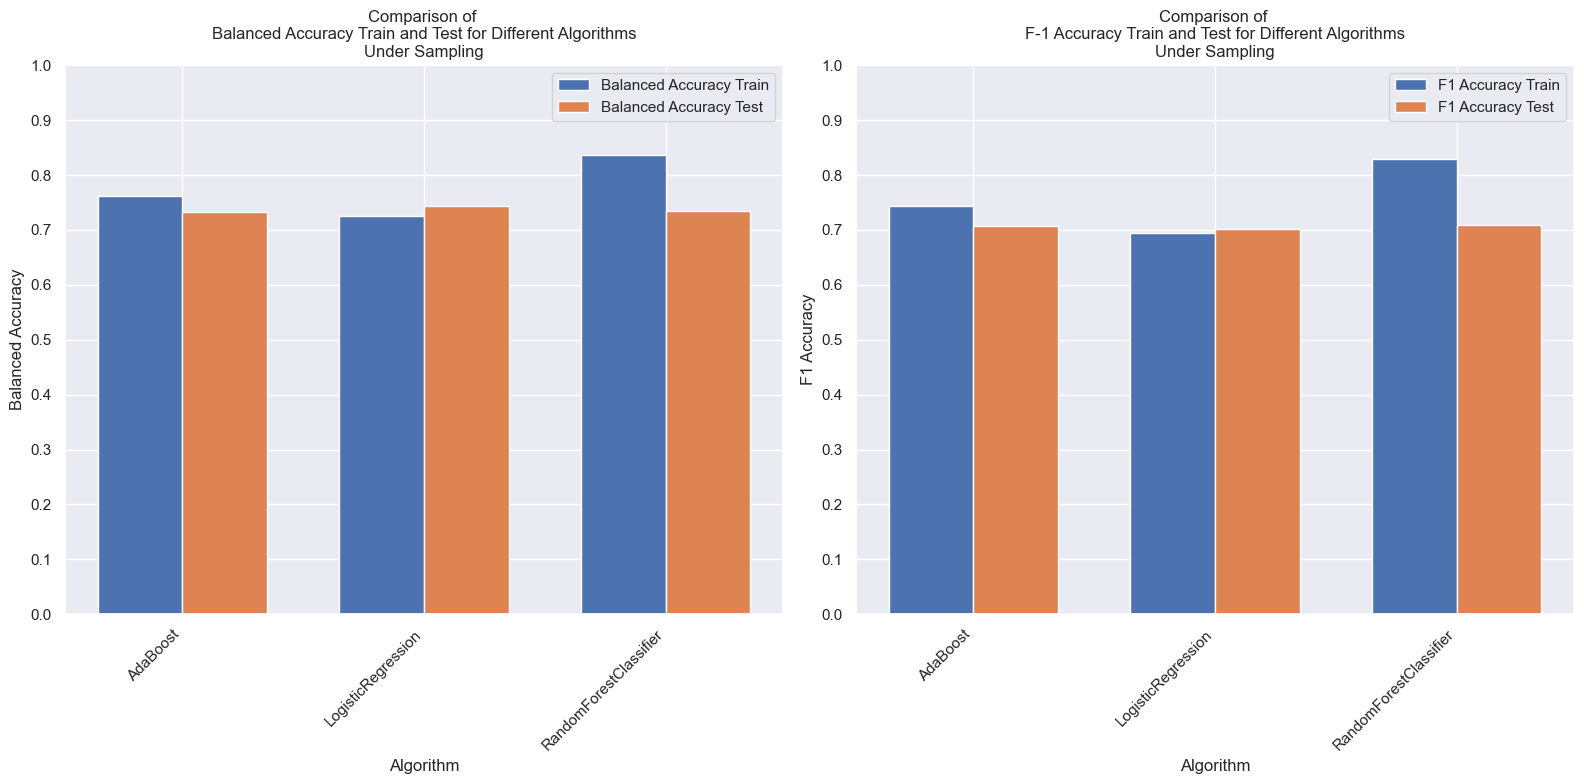

In [72]:
# display plots
plotBar(classify_performance_df, stage=3)

### Under Sampling Calssfication Summary <a class='anchor' id="under_summary"></a>
- There is overfitting in the Random Forest model, as evidenced by the $\approx$11% drop in Balanced Accuracy from the training set to the test set. Hyperparameter tuning may improve the performance of these models further, especially in mitigating overfitting issues. Interestingly, Logistic Regression has a performance increase of $\approx$3%, and the model looks useful, including the model performing better with unseeded data. AdaBoost performance did have a wider gap in sampled data.

											Model=AdaBoost: Over Sample Best Threshold=0.531, F-Score=0.911


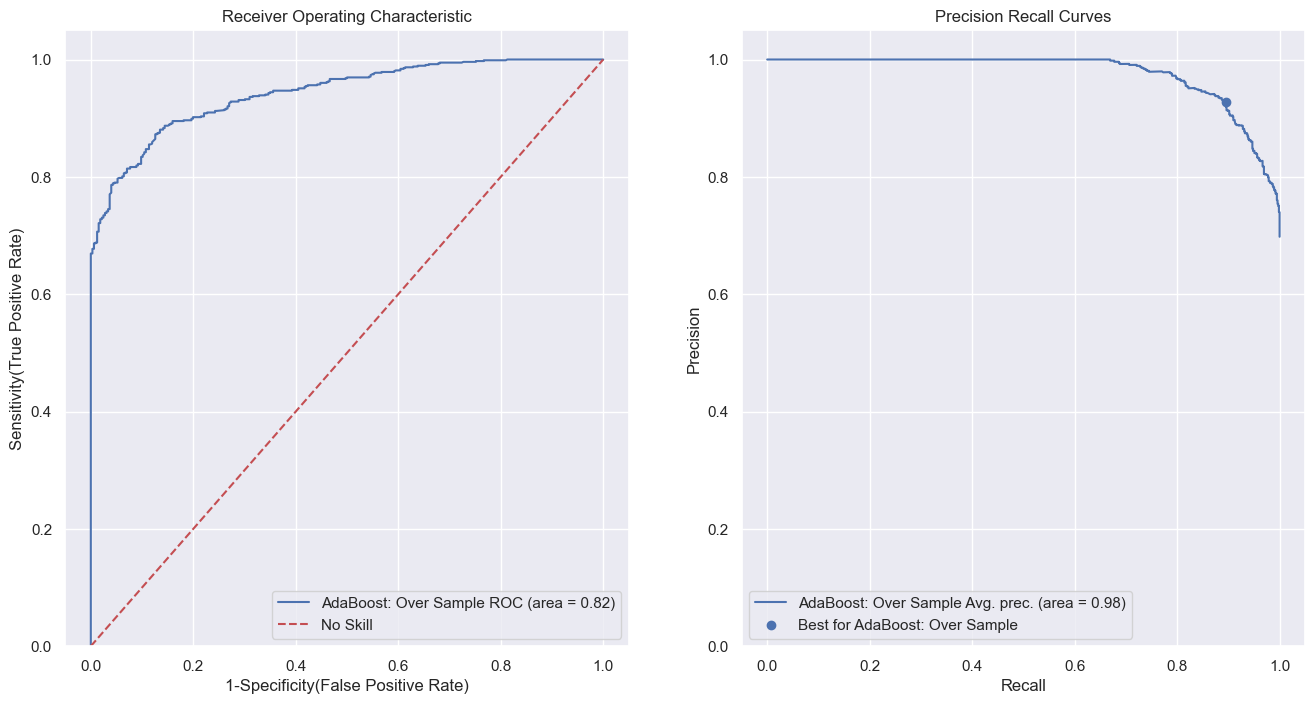

In [74]:
modelsOver = [{'label': 'AdaBoost: Over Sample','marker': 'o','model': model_ada_over,},]

# plot curves
Curve(modelsOver, X_test_scaled, y_test_arr) 

### Conclusion <a class='anchor' id="conclude"></a>

Fourteen features were selected from our engineered data to classify using Machine Learning Model, which had 5,393 data points. Four varied models were used to determine the best model, using Balanced Accuracy and an F-1 score inclduing ROC & Precision & Recall to determine whether a movie is a success or a failure. We experimented with multiple feature selections and over/under-sampling, including stacking various machine-learning models for comparison between the models. The data was normalized using Z-score, and MinMax was used due to feature_selection.chi2 can not use negative values. The Z-score normalization was used for all our machine-learning models.  

In conclusion, various models were used to find the best-performing one. AdaBoost, with Decision Trees as a weak learners ensemble technique, performed the best when the dataset was oversampled. For future experimentation, it would be interesting to incorporate cast and crew information using TF-IDF and PCA for dimensionality reduction, which is intriguing since our visualization provided meaningful information. This would allow us to capture the essence of cast and crew involvement in a more compact and meaningful representation, potentially enhancing our model's predictive power. 